---

<p> Segunda Libreta sobre el trabajo de investigación: </p>

<center>

<p> 
<b>
"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque" 
</b>
</p>

</center>

Autor: Cesar Francisco Vilca Gamarra 

Repositorio alojado en [GitHub](https://github.com/vilcagamarracf/Inv_arroz_METRIC) 

Marzo, 2022

---

# Balance de Energía Superficial - Modelo METRIC

**Satellite-Based Energy Balance for Mapping Evapotranspiration With Internalized Calibration (METRIC)**

Descripción:
- METRIC es un modelo de procesamiento de imágenes para calcular la ET como residuo del balance energético de la superficie.
- METRIC fue desarrollado por la Universidad de Idaho para su aplicación a imágenes de satélite Landsat con el fin de maximizar la resolución del producto ET (30 m).
- METRIC utiliza como base el proceso pionero de balance energético SEBAL desarrollado en los Países Bajos por Bastiaanssen et al..

Aplicación de referencia:
- [geeSEBAL en GitHub](https://github.com/et-brasil/geeSEBAL/blob/a8242225bcb184329372ee0dbdc411d1e9d5c766/JavaScrpit/tools.js)

## Inicio

In [1]:
import ee          # Earth Engine Python API
ee.Initialize()

import os
import numpy as np
import math
from pprint import pprint
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_columns', 30) # Visualizar máximo de 30 columnas

import geemap
import geemap.colormaps as cmp    # Paletas para visualización de imágenes

from funciones import *

In [9]:
# ------------------------------------------------------------------------------------------------
# Pruebas: En caso de realizar alguna edición al archivo 'funciones.py' realizar lo siguiente:
# ------------------------------------------------------------------------------------------------

import importlib
import sys

importlib.reload(sys.modules['funciones']) # Importa las funciones del archivo con las modificaciones aplicadas
from funciones import *

In [2]:
# ------------------------------------------------
# Importando áreas de estudio
# ------------------------------------------------

# Importar asset público: Distrito de Ferreñafe
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', 'FERREÑAFE')
roi = dist_fcol.geometry().bounds()   # ee.Geometry tipo caja

# Importar shapefile de Áreas voladas (archivo en local)
ruta_ferrenafe = r'input/Ferreñafe_areas_2.shp'

# Lectura como FeatureCollection con geemap
predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 2, 2)  # Ver solo bordes, no relleno

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1)  # Ver solo bordes, no relleno

# ------------------------------------------------
# Parámetros de visualización de mapas con geemap
# ------------------------------------------------

# Para imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

# Paletas de colores
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061']  # 0 - 0.5
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']  # -0.2 - 1  '0048fb',
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026']  # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# Parámetros de visualización de gráficas con matplotlib
plt.rcParams['font.family'] = 'serif'  #'serif', 'Arial'  # default es 'sans-serif'
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 72

## Procesamiento

In [3]:
# 6 Imágenes Landsat seleccionadas
lista_ids = [
    'LANDSAT/LC09/C02/T1/LC09_010065_20220113',  # 0 - 01/13 - l9 OJO: NDVI negativos -> Posible riego 01 13
    'LANDSAT/LC09/C02/T1/LC09_010065_20220129',  # 1 - 01/29 - l9 producia error en iteracion hasta bajar el ET
    'LANDSAT/LC08/C02/T1/LC08_010065_20220310',  # 2 - 03/10 - l8 mayoria de superficie cubierta por arroz
    # 'LANDSAT/LC09/C02/T1/LC09_010065_20220403',  # 3 - 04/03 - l9 <------
    'LANDSAT/LC09/C02/T1/LC09_010065_20220505',  # 4 - 05/05 - l9 <------
    'LANDSAT/LC09/C02/T1/LC09_010065_20220521',  # 5 - 05/21 - l9 <------
    'LANDSAT/LC08/C02/T1/LC08_010065_20220614'   # 6 - 06/14 - l8
]

# DEM SRTM 
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores al área de estudio
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

In [4]:
# =============================================================
# Procesar las imagenes e incluirlos en una lista
# =============================================================
# Asignar método de estimación de LAI
# 0: Savi con l=0.1 
# 1: Savi con L=0.5 
# 2: Relación lineal NDVI - IAF: 2.1362*NDVI + 0.0869
# 3: Relación cuadrada NDVI - IAF : 2.3523*NDVI^2 - 1.9013*NDVI + 1.7714
# 4: Savi con L=0.5 y LAI=11*SAVI^3 

lai_method = 4
albedo_method = '0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7'

HR = [
    82, # 0 '2022-01-13'
    81, # 1 '2022-01-29'
    83, # 2 '2022-03-10'
    # 72, # 3 '2022-04-03' # Sin dato
    70, # 4 '2022-05-05' # Sin dato 
    68, # 5 '2022-05-21' # Sin dato
    65  # 6 '2022-06-14'
]

# Lista en blanco que va a contener los resultados
lista_imgprocesadas = []

for index, img_id in enumerate(lista_ids):

    # Imagen Landsat mediante ID
    img_ee = ee.Image(img_id).clip(roi)
    
    # Procesar Radiación Neta (produce un dict)
    img_procesada_dict = getRadiacionNeta(img_ee, roi, dem, 
                                           lai_method, albedo_method, HR[index]) # roi: Ferreñafe

    # Recorte por regiones
    img_procesada_dict['img_productos'] = img_procesada_dict['img_productos'].clip(predios_agricolas)
    img_procesada_dict['img_toa'] = img_procesada_dict['img_toa'].clip(predios_bound)

    # Agregar a lista en blanco
    lista_imgprocesadas.append(img_procesada_dict)

    print(f"Productos y Rn de imagen {img_procesada_dict['fecha']} procesada! lai_method = {lai_method}")
    
n_imgs = len(lista_imgprocesadas)

Productos y Rn de imagen 2022-01-13 procesada! lai_method = 4
Productos y Rn de imagen 2022-01-29 procesada! lai_method = 4
Productos y Rn de imagen 2022-03-10 procesada! lai_method = 4
Productos y Rn de imagen 2022-05-05 procesada! lai_method = 4
Productos y Rn de imagen 2022-05-21 procesada! lai_method = 4
Productos y Rn de imagen 2022-06-14 procesada! lai_method = 4


In [5]:
# Pixeles escogidos mediante comparación ndvi-temperatura
# Pixel frío
list_coords_pixf1 = [
    [-79.78527, -6.598056],  # 0 '2022-01-13' n1: 50 n2: 10   [-79.785803, -6.598076] mejor albedo
    [-79.78472, -6.598345],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10 Nuevo
    [-79.776047, -6.597519], # 4 '2022-05-05' n1: 40 n2: 10 Nuevo
    [-79.778976, -6.605092], # 5 '2022-05-21' n1: 50 n2: 10 Nuevo
    [-79.778737, -6.604828], # 6 '2022-06-14' n1: 50 n2: 5
]

# Pixel caliente
list_coords_pixc1 = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 40 n2: 97 
    [-79.778464, -6.605114], # 1 '2022-01-29' n1: 10 n2: 90
    [-79.777924, -6.604045], # 2 '2022-03-10' n1: 4 n2: 75 
    [-79.778463, -6.603747], # 3 '2022-04-03' n1: 10 n2: 80  
    [-79.784448, -6.598642], # 4 '2022-05-05' n1: 25 n2: 75  
    # [-79.784966, -6.602174], # 4 '2022-05-05'  Prueba en zona de temperaturas altas
    [-79.785537, -6.598398], # 5 '2022-05-21' n1: 30 n2: 80  
    [-79.784729, -6.595629], # 6 '2022-06-14' n1: 10 n2: 80 
]

# Pixeles escogidos mediante relación ndvi-albedo
# pixeles ndvi-albedo
list_coords_pixf = [
    [-79.775487, -6.601604], # 0 '2022-01-13' n1: 50 n2: 10
    [-79.785809, -6.598078], # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984], # 2 '2022-03-10' n1: 50 n2: 5  [-79.782536, -6.601574]
    [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10  [-79.782545, -6.601342]
    [-79.778744, -6.604585], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778718, -6.604593], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778739, -6.604574], # 6 '2022-06-14' n1: 50 n2: 5
]

# Pixeles ndvi-albedo 
list_coords_pixc = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.778464, -6.605114],  # 1 '2022-01-29' n1: 50 n2: 10 
    [-79.777924, -6.604045],  # 2 '2022-03-10' n1: 50 n2: 5 [-79.778736, -6.604317]
    [-79.778468, -6.603759],  # 3 '2022-04-03' n1: 80 n2: 10
    [-79.784448, -6.598642], #[-79.782006, -6.598379],  # 4 '2022-05-05' n1: 40 n2: 10 
    [-79.785537, -6.598398], #[-79.78228, -6.596453],   # 5 '2022-05-21' n1: 50 n2: 10
    [-79.784729, -6.595629]  #[-79.784462, -6.59621],   # 6 '2022-06-14' n1: 50 n2: 5
]

Procesando imagen 2022-01-13 lai_method = 4


coef a: 0.15763394417501805
coef b: -40.51603651163816



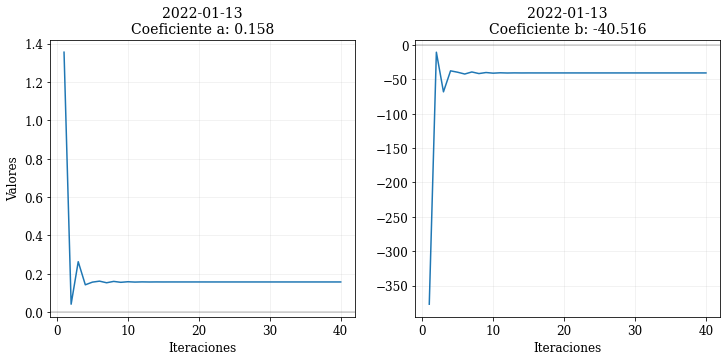


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET,ET_pos
max,26.064854,0.638488,0.905927,0.185278,772.007719,82.234554,575.038528,252.413985,252.413985,8.882268,8.882268
mean,20.429797,0.173787,0.026633,0.108560,685.840959,64.051254,467.382418,154.407287,154.418187,5.436826,5.437210
median,19.969761,0.154227,0.005551,0.105695,687.385429,63.053955,462.532576,163.264781,163.562905,5.777835,5.777835
min,17.866862,-0.147715,-0.003637,0.060885,595.838808,51.978386,437.699962,-13.722458,0.000000,-0.483109,0.000000
mode,19.531407,0.126766,0.001463,0.084236,713.475019,60.799171,457.504966,175.034006,174.644913,6.156311,6.156311
stdDev,1.565502,0.121992,0.067356,0.026231,29.247289,4.911526,18.474519,47.731354,47.694513,1.676638,1.675338


Procesando imagen 2022-01-29 lai_method = 4


coef a: 0.36441732255415304
coef b: -99.52589082798454



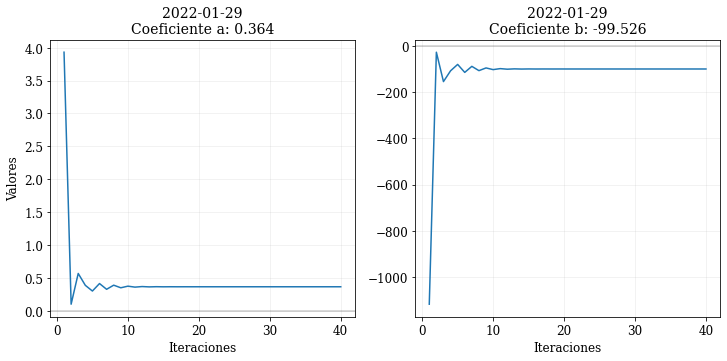


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET,ET_pos
max,21.477840,0.758795,1.877925,0.193713,769.870350,67.980198,763.911743,190.013366,190.013366,6.667931,6.667931
mean,17.445788,0.354347,0.140550,0.104555,700.509783,53.931980,556.786132,89.791671,92.736874,3.153451,3.256933
median,17.516507,0.330639,0.043087,0.103064,701.418714,55.137659,552.982100,96.932554,96.496717,3.405105,3.390038
min,15.563630,0.038919,0.000039,0.055395,619.677496,34.897378,498.511708,-174.222437,0.000000,-6.118508,0.000000
mode,17.639241,0.345717,0.012001,0.093284,706.495383,56.109890,554.990235,116.942884,0.000000,4.100273,0.000000
stdDev,0.770599,0.142571,0.242455,0.024200,24.267049,4.448359,32.644874,50.201987,41.568810,1.762488,1.458946


Procesando imagen 2022-03-10 lai_method = 4


coef a: 0.9405968001440479
coef b: -275.60206757217827



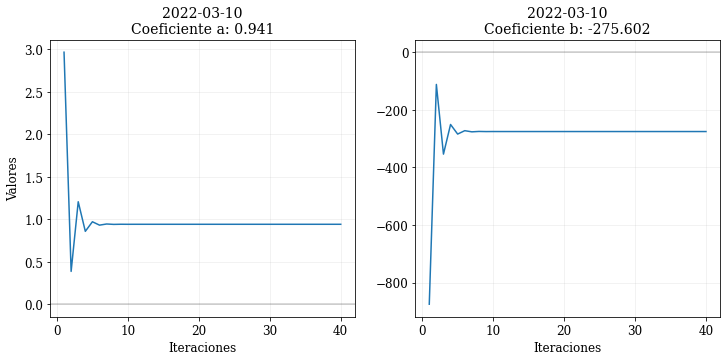


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET,ET_pos
max,29.919813,0.813376,2.122303,0.188104,735.731429,89.702078,979.393263,167.826432,167.826432,5.940267,5.940267
mean,25.684918,0.694646,1.046459,0.142720,639.851290,59.236592,582.915545,-2.300847,24.661073,-0.082310,0.873047
median,25.546380,0.728591,1.085951,0.147870,636.548183,57.637357,574.126029,2.139912,3.531526,0.062160,0.116793
min,24.939735,0.057734,0.000088,0.043423,585.822866,45.137698,460.150098,-456.387666,0.000000,-16.222986,0.000000
mode,25.387842,0.759826,0.003979,0.154788,626.459282,54.627790,589.925747,41.986463,0.005523,0.436266,0.000082
stdDev,0.611619,0.119466,0.452783,0.025791,24.678610,7.924443,58.583589,72.931438,34.466568,2.585274,1.220264


Procesando imagen 2022-05-05 lai_method = 4


coef a: 0.6634165785205943
coef b: -185.47412060570997



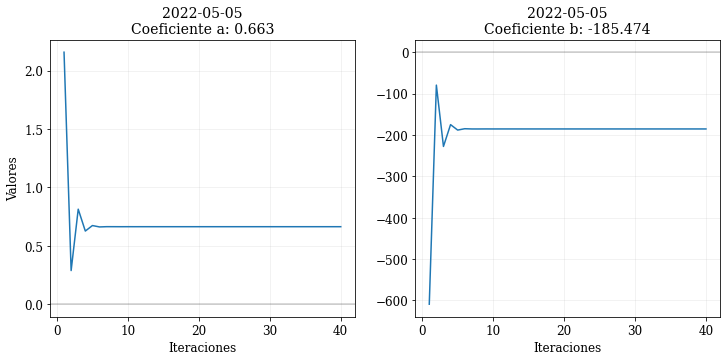


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET,ET_pos
max,16.788747,0.735566,1.557676,0.354990,664.968419,51.456978,573.428419,261.232885,261.232885,9.122667,9.122667
mean,13.510666,0.465731,0.410549,0.185506,590.678301,38.855519,421.147403,130.675379,130.869667,4.571888,4.578703
median,13.423193,0.470679,0.379058,0.176675,596.402704,38.809884,418.765206,138.963941,138.963941,4.844798,4.844798
min,11.343104,0.219831,0.015813,0.086832,445.952245,28.354674,301.140139,-40.829905,0.000000,-1.433223,0.000000
mode,13.328941,0.490262,0.261924,0.174856,603.497477,39.069605,403.152075,141.090082,141.090082,4.906808,4.906808
stdDev,0.661011,0.091834,0.229760,0.034868,31.106293,3.068060,32.553918,47.308328,46.722340,1.654160,1.633585


Procesando imagen 2022-05-21 lai_method = 4


coef a: 0.1594355069966221
coef b: -41.31914734253402



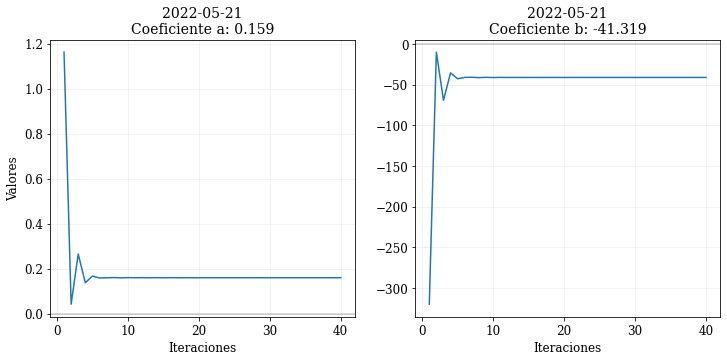


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET,ET_pos
max,21.653865,0.630858,0.835623,0.269867,615.574382,61.092126,448.628748,197.080221,197.080221,6.920000,6.920000
mean,18.738901,0.317700,0.120625,0.194413,538.986769,52.137651,389.851062,96.998057,96.998057,3.410357,3.410357
median,18.799113,0.297891,0.091757,0.193755,538.598321,52.573582,389.736091,96.449291,96.449291,3.390767,3.390767
min,15.447555,0.141125,0.004075,0.117925,474.921426,37.139699,363.763581,12.013210,12.013210,0.423328,0.423328
mode,19.140552,0.276203,0.083768,0.199771,527.494004,51.187848,392.748390,98.637431,98.637431,3.482335,3.482335
stdDev,0.989449,0.065664,0.101014,0.023455,23.434472,3.289676,10.872517,32.047987,32.047987,1.124367,1.124367


Procesando imagen 2022-06-14 lai_method = 4


coef a: 0.1813076884619528
coef b: -49.33130770811982



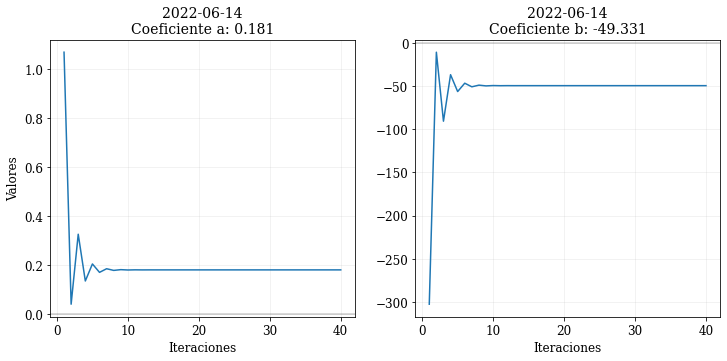


Resultados:


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET,ET_pos
max,31.941024,0.564996,0.576829,0.288857,564.798679,80.742470,435.294427,144.252041,144.252041,5.102792,5.102792
mean,28.697612,0.264333,0.077071,0.177580,490.403604,71.139524,397.187162,22.076918,26.469366,0.782962,0.939132
median,28.294680,0.278310,0.076069,0.179211,490.537089,70.795727,392.226710,23.523451,23.523451,0.844172,0.831412
min,24.168415,0.085178,0.000474,0.085792,399.780832,55.509053,348.755659,-89.792881,0.000000,-3.195009,0.000000
mode,30.516081,0.286231,0.002408,0.192837,479.476816,68.566290,379.755179,29.468284,0.025740,1.031612,0.000794
stdDev,1.619056,0.089286,0.081282,0.037171,27.243118,4.133667,18.259737,30.704353,23.444783,1.089302,0.830796


,coef_a,coef_b
13-Ene,0.157634,-40.516037
29-Ene,0.364417,-99.525891
10-Mar,0.940597,-275.602068
05-May,0.663417,-185.474121
21-May,0.159436,-41.319147
14-Jun,0.181308,-49.331308


In [6]:
# =============================================================
# Inputs iniciales
# =============================================================

# En caso de guardar los archivos
save_files = True
carpeta_output = 'output'

elev_station = 2.9 # m
n_iteraciones = 40 # <-- Establecer cantidad de iteraciones

lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '05-May', '21-May', '14-Jun'] # '03-Abr', 

# =============================================================
# Datos de estación: Velocidad de viento y ET
list_weather_st = [
    [1.6*3.6, 0.13], # 0 '2022-01-13' 1.6
    [1.6*3.6, 0.15], # 1 '2022-01-29'
    [3.2*3.6, 0.20], # 2 '2022-03-10' 3.2 (original)
    # [3.2*3.6, 0.17], # 3 '2022-04-03' 1.6
    [3.2*3.6, 0.20], # 4 '2022-05-05'
    [1.6*3.6, 0.20], # 5 '2022-05-21'
    [1.6*3.6, 0.16]  # 6 '2022-06-14' (original)
] # km/h

# Coordenadas previamente seleccionados (Pixel Frio)
# pixeles ndvi-albedo
list_coords_pixf = [
    [-79.775487, -6.601604], # 0 '2022-01-13' n1: 50 n2: 10
    [-79.785809, -6.598078], # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445,  -6.596984], # 2 '2022-03-10' n1: 50 n2: 5  [-79.782536, -6.601574]
    # [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10  [-79.782545, -6.601342]
    [-79.778744, -6.604585], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778718, -6.604593], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778739, -6.604574], # 6 '2022-06-14' n1: 50 n2: 5
]

# Coordenadas previamente seleccionados (Pixel Caliente)
# Pixeles ndvi-albedo 
list_coords_pixc = [
    [-79.78198 , -6.602693],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.778464, -6.605114],  # 1 '2022-01-29' n1: 50 n2: 10 
    [-79.777924, -6.604045],  # 2 '2022-03-10' n1: 50 n2: 5 [-79.778736, -6.604317]
    # [-79.778468, -6.603759],  # 3 '2022-04-03' n1: 80 n2: 10
    [-79.784448, -6.598642],  #[-79.782006, -6.598379],  # 4 '2022-05-05' n1: 40 n2: 10 
    [-79.785537, -6.598398],  #[-79.78228, -6.596453],   # 5 '2022-05-21' n1: 50 n2: 10
    [-79.784729, -6.595629]   #[-79.784462, -6.59621],   # 6 '2022-06-14' n1: 50 n2: 5
]

# =============================================================
# Procesamiento
# =============================================================

lista_imgprocesadas_ET = [] # Lista vacía que almacenará resultados

for index in range(n_imgs):

    # Selección de datos
    img_seleccionada = lista_imgprocesadas[index]
    img_productos = img_seleccionada['img_productos']
    d2 = img_seleccionada['d2']
    fecha = img_seleccionada['fecha']

    print(f'Procesando imagen {fecha} lai_method = {lai_method}\n')
    
    # Generar estadísticas y guardar en DataFrame
    img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
    img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')

    # =============================================================
    # 1. Establecer valores de pixel frío y caliente
    # Selección de datos mediante el'index'
    # =============================================================

    filtrado_ws, filtrado_et = list_weather_st[index]

    pixf_coord = list_coords_pixf[index]
    pixf_ee_coord = ee.Geometry.Point(pixf_coord)
    pix_f_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

    pixc_coord = list_coords_pixc[index]
    pixc_ee_coord = ee.Geometry.Point(pixc_coord)
    pix_c_values = get_pixel_values(pixc_ee_coord, d2, img_productos)

    # Valores obtenidos por get_pixel_values
    df_pixeles = pd.DataFrame.from_dict({'PixF':pix_f_values, 
                                         'PixC':pix_c_values}, orient='columns')
    # Añadir Longitud y Latitud a los pixeles
    lonlat = {'PixF': list_coords_pixf[index], 'PixC': list_coords_pixc[index]}
    df_lonlat = pd.DataFrame(data=lonlat, index=['Longitud', 'Latitud'])
    
    df_pixeles = pd.concat([df_pixeles, df_lonlat])
    
    # Exportar datos de pixeles
    df_pixeles.to_csv(os.path.join(carpeta_output, f'{fecha}_pixeles_selec.csv')) 
        
    # =============================================================
    # 2. Flujo de calor sensible H - Proceso Iterativo
    # =============================================================
    resultados_f, resultados_c = parte_iterativa(n_iteraciones,
                                                 elev_station,
                                                 pix_f_values, pix_c_values, 
                                                 filtrado_ws, filtrado_et)

    resultados_f_df = pd.DataFrame(resultados_f)
    resultados_c_df = pd.DataFrame(resultados_c)
    # display(resultados_c_df)

    # Guardar dataframe
    resultados_f_df.to_csv(os.path.join(carpeta_output, f'{fecha}_iteraciones_pixf.csv'))
    resultados_c_df.to_csv(os.path.join(carpeta_output, f'{fecha}_iteraciones_pixc.csv'))

    # Coeficientes a y b finales de selección de pixeles frío y caliente
    coef_a = resultados_f[-1]['a_coef']
    coef_b = resultados_f[-1]['b_coef']
    print(f'\ncoef a: {coef_a}\ncoef b: {coef_b}\n')

    # Guardar Gráfica 1x2 
    grafica_coefs(resultados_f_df, fecha, coef_a, coef_b,
                  save_files=os.path.join(carpeta_output, f'{fecha}_coefs.png'))

    # =============================================================
    # 3. Componentes de balance de energía
    # =============================================================

    # 1. Rn
    R_n = img_seleccionada['img_Rn']
    img_Rn = R_n.select('R_n').clip(predios_agricolas)

    # 2. G
    img_tempK = img_productos.select('Ts_k')
    img_G = img_tempK.expression('(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
                                 {'Ts_K': img_tempK,
                                  'albedo': img_productos.select('albedo'),
                                  'NDVI': img_productos.select('NDVI')}
                                ).multiply(R_n.select('R_n'))

    # 3. H
    img_H = get_H_corregido(img_productos, resultados_c, dem, elev_station)
    img_H_stats = get_stats(img_H, predios_agricolas, 30)
    # display(img_H_stats)

    # =============================================================
    # 4. Balance de energía: LE = Rn - G - H
    # Si H es superior a Rn, se producirán valores negativos de LE
    # =============================================================
    img_LE = img_Rn.expression('Rn - G - H',
                               {'Rn': img_Rn,
                                'G': img_G,
                                'H': img_H})

    # Filtrando valores negativos
    # img_LE_gt0 = img_LE.updateMask(img_LE.gt(0)) # Recorta
    img_LE_gt0 = img_LE.where(img_LE.lte(0), 0) # Filtra
    
    # Unir los componentes en una sola imagen
    img_compbalance = ee.Image([img_Rn, img_G, img_H, img_LE, img_LE_gt0]).rename(['0_Rn', '1_G', '2_H', '3_LE', '3_LE_vis'])
    img_compbalance_stats = get_stats(img_compbalance, predios_agricolas, 30)
    img_compbalance_stats_df = pd.DataFrame.from_dict(img_compbalance_stats, orient='index', dtype='float') # .round(3)

    # =============================================================
    # 5. Evapotranspiración del cultivo ETinst (mm/hr y mm/d)
    # =============================================================

    # ET (mm/hr)
    img_lambda = img_tempK.expression('(2.501 - 0.00236*(Ts - 273.15))*10**6', {'Ts':img_tempK}).rename('lambda')
    img_ET_inst = img_LE.expression('3600*img_LE/lambda', {'img_LE': img_LE,'lambda': img_lambda}).rename('ET')
    img_ET_inst_pos = img_LE_gt0.expression('3600*img_LE/lambda', {'img_LE': img_LE_gt0,'lambda': img_lambda}).rename('ET_pos')
    
    # ET (mm/día)      mm/hr * 24 hrs/dia = mm/dia
    img_ET_inst = img_ET_inst.multiply(24) 
    img_ET_inst_pos = img_ET_inst_pos.multiply(24)

    # Generar estadísticas y guardar en dataframe
    img_ET_inst_stats = get_stats(img_ET_inst, predios_agricolas, 30)
    img_ET_inst_stats_pos = get_stats(img_ET_inst_pos, predios_agricolas, 30)
    
    img_ET_inst_stats_df = pd.DataFrame.from_dict(img_ET_inst_stats, orient='index', dtype='float')#.round(3)
    img_ET_inst_stats_pos_df = pd.DataFrame.from_dict(img_ET_inst_stats_pos, orient='index', dtype='float')#.round(3)

    # =============================================================
    # 6. Resultados
    # =============================================================

    # Generar dataframe final
    lista_dfs = [
        img_productos_df[['Ts_c', 'NDVI', 'LAI', 'albedo']], 
        img_compbalance_stats_df, 
        img_ET_inst_stats_df,
        img_ET_inst_stats_pos_df
    ]
    df_stats = pd.concat(lista_dfs, axis=1)
    df_stats.to_csv(os.path.join(carpeta_output, f'{fecha}_resultados.csv'))
    
    # Visualización de resultados para comprobación
    print('\nResultados:')
    display(df_stats)
    
    # Unir imagenes de componentes y ET procesadas en una lista
    img_seleccionada['img_CompBalance'] = img_compbalance # ee.Image
    img_seleccionada['img_ETinst'] = img_ET_inst    # ee.Image
    img_seleccionada['pixeles_stats'] = df_pixeles  # df de valores solamente de pixeles 
    img_seleccionada['stats'] = df_stats            # df general de la imagen
    img_seleccionada['pix_f'] = resultados_f_df     # df (f de frío)
    img_seleccionada['pix_c'] = resultados_c_df     # df (c de caliente)
    img_seleccionada['pixeles'] = {'coef_a':coef_a, 'coef_b':coef_b} 
    
    # Finalmente agregamos cada imagen procesada a una lista
    lista_imgprocesadas_ET.append(img_seleccionada)

# Coeficientes finales
tabla_coefs(lista_imgprocesadas_ET, n_imgs, lista_fechas, 
            save_files=os.path.join(carpeta_output, 'tabla_coeficientes.csv'))

# lista_imgprocesadas_ET[index]['stats'] # Para ver los datos de las iteraciones por imagen

### Tablas

In [8]:
tabla_pixeles(lista_imgprocesadas_ET, 
              lista_fechas)
              #save_files=os.path.join(carpeta_output, 'tabla_pixeles_LAI4.csv'))

,Fecha,Pixel,Longitud,Latitud,NDVI,Albedo,Ts (K),a,b
0,13-Ene,P. Frío,-79.775487,-6.601604,0.638243,0.180693,293.002699,0.157634,-40.516037
1,13-Ene,P. Cal.,-79.781980,-6.602693,0.134990,0.164048,299.214854,0.157634,-40.516037
0,29-Ene,P. Frío,-79.785809,-6.598078,0.758795,0.193713,288.863523,0.364417,-99.525891
1,29-Ene,P. Cal.,-79.778464,-6.605114,0.151251,0.129899,291.796699,0.364417,-99.525891
0,10-Mar,P. Frío,-79.784450,-6.596984,0.739550,0.133570,298.091980,0.940597,-275.602068
1,10-Mar,P. Cal.,-79.777924,-6.604045,0.167542,0.061233,300.230260,0.940597,-275.602068
0,05-May,P. Frío,-79.778744,-6.604585,0.723952,0.172390,285.992925,0.663417,-185.474121
1,05-May,P. Cal.,-79.784448,-6.598642,0.332702,0.249469,287.832641,0.663417,-185.474121
0,21-May,P. Frío,-79.778718,-6.604593,0.622461,0.155652,288.802154,0.159436,-41.319147
1,21-May,P. Cal.,-79.785537,-6.598398,0.263497,0.251122,294.067755,0.159436,-41.319147


In [10]:
# Tabla de rangos (2 decimales)
def rangos(index, variable):
    
    promedio = lista_imgprocesadas_ET[index]['stats'][variable]['mean']
    minimo = lista_imgprocesadas_ET[index]['stats'][variable]['min']
    maximo = lista_imgprocesadas_ET[index]['stats'][variable]['max']
    rangos_valores = f"{promedio:.2f} ({minimo:.2f} - {maximo:.2f})"
    return rangos_valores

lista_nombres = ['NDVI', 'LAI', 'Albedo', 'Rn (W m-2)', 'G (W m-2)', 'H (W m-2)', 'ETc (mm d-1)', 'ETc pos (mm d-1)']
lista_variables = ['NDVI', 'LAI', 'albedo', '0_Rn', '1_G', '2_H', 'ET', 'ET_pos']
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']

# Armar cuadro estadístico x(min-max)
lista_resultados = []
for index in range(n_imgs):
    result_int = []
    for variable in lista_variables:
        valores = rangos(index, variable)
        result_int.append(valores)
    dict_result = {f"{lista_fechas[index]}": result_int}
    df = pd.DataFrame(data=dict_result, index=lista_nombres)
    lista_resultados.append(df)

# Unir dfs en uno solo
df_resultados = pd.concat(lista_resultados, axis=1) # df_resultados.T para transpuesta
# df_resultados.to_csv(os.path.join(carpeta_output, 'tabla_resumen.csv'))
df_resultados

,13-Ene,29-Ene,10-Mar,05-May,21-May,14-Jun
NDVI,0.17 (-0.15 - 0.64),0.35 (0.04 - 0.76),0.69 (0.06 - 0.81),0.47 (0.22 - 0.74),0.32 (0.14 - 0.63),0.26 (0.09 - 0.56)
LAI,0.03 (-0.00 - 0.91),0.14 (0.00 - 1.88),1.05 (0.00 - 2.12),0.41 (0.02 - 1.56),0.12 (0.00 - 0.84),0.08 (0.00 - 0.58)
Albedo,0.11 (0.06 - 0.19),0.10 (0.06 - 0.19),0.14 (0.04 - 0.19),0.19 (0.09 - 0.35),0.19 (0.12 - 0.27),0.18 (0.09 - 0.29)
Rn (W m-2),685.84 (595.84 - 772.01),700.51 (619.68 - 769.87),639.85 (585.82 - 735.73),590.68 (445.95 - 664.97),538.99 (474.92 - 615.57),490.40 (399.78 - 564.80)
G (W m-2),64.05 (51.98 - 82.23),53.93 (34.90 - 67.98),59.24 (45.14 - 89.70),38.86 (28.35 - 51.46),52.14 (37.14 - 61.09),71.14 (55.51 - 80.74)
H (W m-2),467.38 (437.70 - 575.04),556.79 (498.51 - 763.91),582.92 (460.15 - 979.39),421.15 (301.14 - 573.43),389.85 (363.76 - 448.63),397.19 (348.76 - 435.29)
ETc (mm d-1),5.44 (-0.48 - 8.88),3.15 (-6.12 - 6.67),-0.08 (-16.22 - 5.94),4.57 (-1.43 - 9.12),3.41 (0.42 - 6.92),0.78 (-3.20 - 5.10)
ETc pos (mm d-1),5.44 (0.00 - 8.88),3.26 (0.00 - 6.67),0.87 (0.00 - 5.94),4.58 (0.00 - 9.12),3.41 (0.42 - 6.92),0.94 (0.00 - 5.10)


In [36]:
# Tabla de rangos (2 decimales)
def rangos(index, variable):
    
    promedio = lista_imgprocesadas_ET[index]['stats'][variable]['mean']
    minimo = lista_imgprocesadas_ET[index]['stats'][variable]['min']
    maximo = lista_imgprocesadas_ET[index]['stats'][variable]['max']
    rangos_valores = f"{promedio:.2f} ({minimo:.2f} - {maximo:.2f})"
    return rangos_valores

lista_nombres = ['NDVI', 'LAI', 'Albedo', 'Rn (W m-2)', 'G (W m-2)', 'H (W m-2)', 'ETc (mm d-1)', 'ETc pos (mm d-1)']
lista_variables = ['NDVI', 'LAI', 'albedo', '0_Rn', '1_G', '2_H', 'ET', 'ET_pos']
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']

# Armar cuadro estadístico x(min-max)
lista_resultados = []
for index in range(n_imgs):
    result_int = []
    for variable in lista_variables:
        valores = rangos(index, variable)
        result_int.append(valores)
    dict_result = {f"{lista_fechas[index]}": result_int}
    df = pd.DataFrame(data=dict_result, index=lista_nombres)
    lista_resultados.append(df)

# Unir dfs en uno solo
df_resultados = pd.concat(lista_resultados, axis=1) # df_resultados.T para transpuesta
df_resultados.to_csv(os.path.join(carpeta_output, 'tabla_resumen.csv'))
df_resultados

,13-Ene,29-Ene,10-Mar,03-Abr,05-May,21-May,14-Jun
NDVI,0.17 (-0.15 - 0.64),0.35 (0.04 - 0.76),0.69 (0.06 - 0.81),0.68 (0.24 - 0.77),0.47 (0.22 - 0.74),0.32 (0.14 - 0.63),0.26 (0.09 - 0.56)
LAI,0.03 (-0.00 - 0.91),0.14 (0.00 - 1.88),1.05 (0.00 - 2.12),1.10 (0.02 - 1.75),0.41 (0.02 - 1.56),0.12 (0.00 - 0.84),0.08 (0.00 - 0.58)
Albedo,0.11 (0.06 - 0.19),0.10 (0.06 - 0.19),0.14 (0.04 - 0.19),0.16 (0.10 - 0.20),0.19 (0.09 - 0.35),0.19 (0.12 - 0.27),0.18 (0.09 - 0.29)
Rn (W m-2),685.84 (595.84 - 772.01),700.51 (619.68 - 769.87),639.85 (585.82 - 735.73),658.04 (612.08 - 729.25),590.68 (445.95 - 664.97),538.99 (474.92 - 615.57),490.40 (399.78 - 564.80)
G (W m-2),64.05 (51.98 - 82.23),53.93 (34.90 - 67.98),59.24 (45.14 - 89.70),37.47 (30.44 - 58.66),38.86 (28.35 - 51.46),52.14 (37.14 - 61.09),71.14 (55.51 - 80.74)
H (W m-2),467.38 (437.70 - 575.04),556.79 (498.51 - 763.91),582.92 (460.15 - 979.39),634.29 (509.94 - 932.18),421.15 (301.14 - 573.43),389.85 (363.76 - 448.63),397.19 (348.76 - 435.29)
ETc (mm d-1),5.44 (-0.48 - 8.88),3.15 (-6.12 - 6.67),-0.08 (-16.22 - 5.94),-0.48 (-12.37 - 5.25),4.57 (-1.43 - 9.12),3.41 (0.42 - 6.92),0.78 (-3.20 - 5.10)
ETc pos (mm d-1),5.44 (0.00 - 8.88),3.26 (0.00 - 6.67),0.87 (0.00 - 5.94),0.40 (0.00 - 5.25),4.58 (0.00 - 9.12),3.41 (0.42 - 6.92),0.94 (0.00 - 5.10)


### Revisar imagenes

In [10]:
get_stats(Ts_dem, predios_agricolas, 30)

{'max': {'Ts_k': 305.36487286879725},
 'mean': {'Ts_k': 302.1130275605323},
 'median': {'Ts_k': 301.70086780486656},
 'min': {'Ts_k': 297.56598075457583},
 'mode': {'Ts_k': 300.6386654882428},
 'stdDev': {'Ts_k': 1.626703868351111}}

In [15]:
get_stats(img_dT, predios_agricolas, 30)

{'max': {'dT': 12.026943097944056},
 'mean': {'dT': 10.77485899463043},
 'median': {'dT': 10.615225002301734},
 'min': {'dT': 9.024073061397047},
 'mode': {'dT': 10.210838289210285},
 'stdDev': {'dT': 0.6263428488243965}}

In [17]:
get_stats(air_pressureP, predios_agricolas, 30)

{'max': {'constant': 100.82830832229618},
 'mean': {'constant': 100.75613845328498},
 'median': {'constant': 100.75770825535405},
 'min': {'constant': 100.66363711640493},
 'mode': {'constant': 100.76947215205384},
 'stdDev': {'constant': 0.024090406369826903}}

In [18]:
get_stats(air_dens_p, predios_agricolas, 30)

{'max': {'air_dens': 1.2060642042527694},
 'mean': {'air_dens': 1.1942541404650158},
 'median': {'air_dens': 1.1951444428962048},
 'min': {'air_dens': 1.1862133996762003},
 'mode': {'air_dens': 1.197318729007931},
 'stdDev': {'air_dens': 0.004087849553484041}}

In [16]:
air_pressureP = dem.expression(
    '101.3*( (293.15-0.0065*dem_elev)/293.15)**5.26',
    {'dem_elev': dem})

air_dens_p = air_pressureP.expression(
    '1000*air_pressureP/(1.01*(air_tempK)*287)',
    {'air_pressureP': air_pressureP,
     'air_tempK': img_tempK.subtract(img_dT)}).rename('air_dens')


In [14]:
img_tempk = lista_imgprocesadas[n_img]['img_productos'].select('Ts_k')
Ts_dem = img_tempK.expression('img_tempK + Tlapse_rate/1000*(dem_elev-elev_station)',
                              {'img_tempK': img_tempK,
                               'Tlapse_rate': 6.5,
                               'dem_elev': dem,
                               'elev_station': elev_station})
pixeles = lista_imgprocesadas_ET[n_img]['pixeles']

# img_dT = b + a*Ts_dem
img_dT = Ts_dem.expression('b + a*Ts_dem',
                           {'a': pixeles['coef_a'], 'b': pixeles['coef_b'], 'Ts_dem': Ts_dem}).rename('dT')

In [9]:
# lista_imgprocesadas_ET[n_img]['img_CompBalance']

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(Ts_dem, {}, 'ts_dem')
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [16]:
lista_imgprocesadas[3]['d2'].getInfo()

1.0004262213577246

In [7]:
# Visualizar imágenes

# 0 '2022-01-13'
# 1 '2022-01-29'
# 2 '2022-03-10'
# 3 '2022-04-03'
# 4 '2022-05-05'
# 5 '2022-05-21'
# 6 '2022-06-14'

n_img = 0

# Mapas a visualizar
img_temp = lista_imgprocesadas[n_img]['img_productos'].select('Ts_c')
img_rgb = lista_imgprocesadas[n_img]['img_toa'].clip(predios_bound)
fecha = lista_imgprocesadas[n_img]['fecha']
img_albedo = lista_imgprocesadas[n_img]['img_productos'].select('albedo')
img_lai = lista_imgprocesadas[n_img]['img_productos'].select('LAI')

print(fecha)

img_H = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('2_H')
img_Rn = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('0_Rn')
img_le = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('3_LE_vis')

img_ndvi = lista_imgprocesadas[n_img]['img_productos'].select('NDVI')

# Seleccionar imagen ET
img_ET = lista_imgprocesadas_ET[n_img]['img_ETinst']
img_ETpos = img_ET.updateMask(img_ET.gte(0))
img_ETnega = img_ET.updateMask(img_ET.lt(0))

img_albedo_rangos = img_albedo.updateMask(img_albedo.gte(0.17))

# Parámetros de visualización
paleta_ET = ["F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"]

vis_params_ndvi = {'min': 0,#lista_imgprocesadas_ET[n_img]['stats']['NDVI']['min'],
                   'max': 1,#lista_imgprocesadas_ET[n_img]['stats']['NDVI']['max'],
                   'palette': ndvi_cmap}

vis_params_lai = {
    'min': 0,
    'max': 2,
    'palette': ndvi_cmap#cmp.get_palette('gray') 
}
vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': ndvi_cmap#cmp.get_palette('gray') 
}
vis_params_alb_rangos = {
    'min': 0.17,
    'max': 0.25,
    'palette': ndvi_cmap #cmp.get_palette('gray') 
}

vis_paramsp = {'min': 0, 
               'max': 10, 
               # 'max': int(max_et), 
               'palette': paleta_ET} #cmp.get_palette('Grays')} 

vis_paramset = {'min': 0, 
               'max': 10, 
               # 'max': int(max_et), 
               'palette': paleta_ET} #cmp.get_palette('Grays')}

vis_paramsn = {'min': lista_imgprocesadas_ET[n_img]['stats']['ET']['min'],  
               'max': 0, 
               'palette': cmp.get_palette('Reds_r')} 

vis_paramst = {'min': lista_imgprocesadas_ET[n_img]['stats']['Ts_c']['min'],  
               'max': lista_imgprocesadas_ET[n_img]['stats']['Ts_c']['max'], 
               'palette': cmp.get_palette('RdYlBu_r')}  # YlGnBu

vis_params_le = {'min': lista_imgprocesadas_ET[n_img]['stats']['3_LE_vis']['min'],  
                 'max': lista_imgprocesadas_ET[n_img]['stats']['3_LE_vis']['max'], 
                 'palette': ndvi_cmap}#cmp.get_palette('RdYlBu_r')}  # YlGnBu

vis_params_H = {'min': lista_imgprocesadas_ET[n_img]['stats']['2_H']['min'], 
                'max': lista_imgprocesadas_ET[n_img]['stats']['2_H']['max'], 
                'palette': cmp.get_palette('Grays')}

display(lista_imgprocesadas_ET[n_img]['stats'])

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')

Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(img_albedo, vis_params_alb, 'albedo')
Map.addLayer(img_lai, vis_params_lai, 'lai')

Map.addLayer(img_ET, vis_paramset, 'img_ET')
Map.addLayer(img_ETpos, vis_paramsp, 'img_ETpos')
Map.addLayer(img_ETnega, vis_paramsn, 'img_ETnega')

Map.addLayer(img_H, vis_params_H, 'img_H')
Map.addLayer(img_le, vis_params_le, 'img_le')
Map.addLayer(img_temp, vis_paramst, 'img_temp')

# Map.addLayer(img_albedo_rangos, vis_params_alb_rangos, 'albedo_gt17')

# Prueba: Selección de pixeles
# Map.addLayer(ee.Geometry.Point(list_coords_pixf1[n_img]), {}, 'Pixel F anterior')
# Map.addLayer(ee.Geometry.Point(list_coords_pixf[n_img]), {}, 'Pixel F')
# Map.addLayer(ee.Geometry.Point(list_coords_pixc1[n_img]), {}, 'Pixel C anterior')
# Map.addLayer(ee.Geometry.Point(list_coords_pixc[n_img]), {}, 'Pixel C')

# Map.addLayer(ee.Geometry.Point(), {}, 'Pixel C final')

Map.add_colorbar(vis_paramset, orientation='horizontal') #, label='ET')
Map

2022-01-13


,Ts_c,NDVI,LAI,albedo,0_Rn,1_G,2_H,3_LE,3_LE_vis,ET
max,26.066006,0.638488,0.922158,0.185254,772.328767,82.277447,578.031242,251.982392,251.982392,8.867080
mean,20.426264,0.173787,0.045677,0.108548,686.110537,64.064258,468.905068,153.141211,153.173034,5.392227
median,19.968177,0.154227,0.000028,0.105683,687.494991,63.070315,463.461803,163.369398,162.708563,5.722259
min,17.866862,-0.147715,0.000000,0.060872,596.081181,51.980854,438.532979,-18.395543,0.000000,-0.648556
mode,19.529479,0.126766,0.000028,0.084238,696.470801,62.051227,457.485348,174.871352,174.470390,6.152229
stdDev,1.565740,0.121992,0.104066,0.026230,29.253303,4.916764,19.228541,48.402281,48.296241,1.700371


Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')
Map.addLayer(img_H, vis_params_H, 'img_H')
Map.addLayer(img_ETnega, vis_paramsn, 'img_ETnega')
Map

Map(center=[-6.599808497116164, -79.78073669859754], controls=(WidgetControl(options=['position', 'transparent…

In [13]:
Map.user_rois.geometry().coordinates().getInfo() 

[-79.776576, -6.602948]

#### LAI

In [51]:
ndvi_cmap = ['ffffff', 
             'ce7e45', 
             'fad163',
             "8BFF00",
             '74a909',
             '3a7405', 
             '1a3b03',
             "0000FF"]  # -0.2 - 1  '0048fb',

lai_paleta = ['ffffff', 'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301']

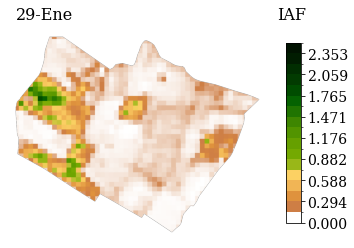

In [58]:
lista_variables = ['NDVI', 'LAI', 'albedo', 'Ts_c']
vis_params_lai = {'min': 0, 'max': 2,  'palette': lai_paleta}
index = 1
img_productos = lista_imgprocesadas[index]['img_productos']
img = img_productos.select(lista_variables[1])

get_grafica_cartoee_color(img, 
                          vis_params_lai,      
                          figsize=(5,5),
                          text=lista_fechas[index], 
                          title_map=None,
                          label= 'IAF', #'ETc ($mm\;d^{-1}$)', 
                          # save_fig=os.path.join(carpeta_output, f"ET_{lista_imgprocesadas[-1]['fecha']}"),
                          nogrid=True,
                          scale_bar=None)

### Gráficas con cartoee

In [10]:
from geemap import cartoee        # Elaboración de gráficas
import cartopy.crs as ccrs        # Importar sistema de coordenadas para gráficas

In [11]:
lista_fechas

['13-Ene', '29-Ene', '10-Mar', '05-May', '21-May', '14-Jun']

#### Gráfica NDVI-IAF-Albedo-Ts

In [15]:
cmap_albedo = [
  '#d71a18', # 0.00 - 0.05
  '#ea603c', # 0.05 - 0.10
  '#f8af64', # 0.10 - 0.15
  '#ffd293', # 0.15 - 0.20
  '#fffebd', # 0.20 - 0.25
  '#d1ebcd', # 0.25 - 0.30
]

In [ ]:


# cmap_ndvi = ['ffffff', 
#              'ce7e45', 'df923d', 'f1b555',
#              '74a909',
#              '3a7405', 
#              '1a3b03']

# cmap_ndvi2 = ['ffffff', 
#              'ce7e45', 'df923d', 'f1b555',
#              '99b718', '74a901', '66a000', '529400']

# cmap_lai = ['ffffff', 
#              'ce7e45','ce7e45', 
#              'fad163','fad163',
#              '74a909','74a909',
#              '3a7405','3a7405', 
#              '1a3b03','1a3b03']  # -0.2 - 1  '0048fb',

# # paleta de Earth Engine
# cmap_lai2 = [
#   # 'ffffff', 
#              'ce7e45', 'df923d', 'f1b555', 'fcd163', 
#              '99b718', '74a901', '66a000', '529400', '3e8601', 
#              '207401', '056201', '004c00', '023b01', '012e01', 
#              '011d01', '011301']

# cmap_lai3 = ['3b0200', '977705', 'ca9f06', 'ffca09', '006a03', '003b02']

# cmap_lai4 = ['ffffff', 
#              'ce7e45', 'df923d', 'f1b555',
#              'fad163', '74a909', '3a7405', '1a3b03'] 

# lai_paleta = ['ffffff', 
#               'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
#     '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
#     '012e01', '011d01', '011301']

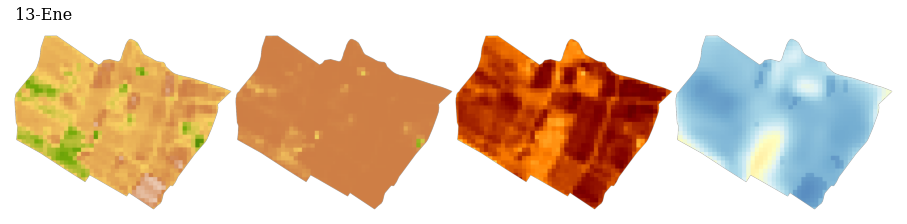

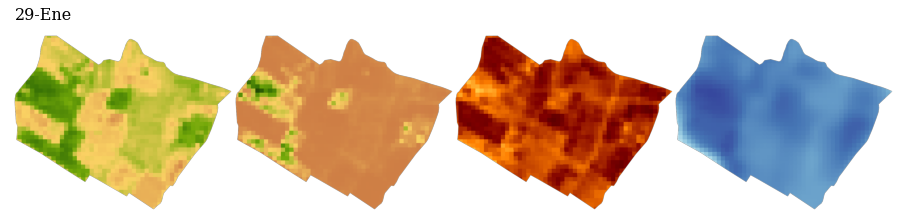

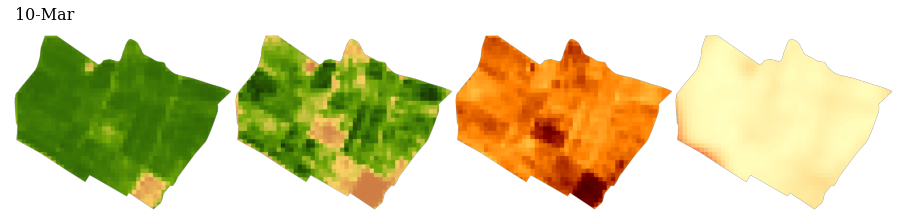

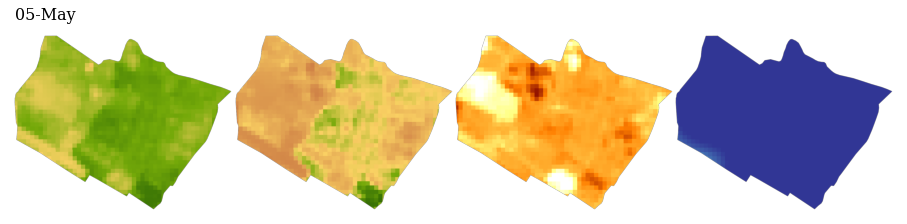

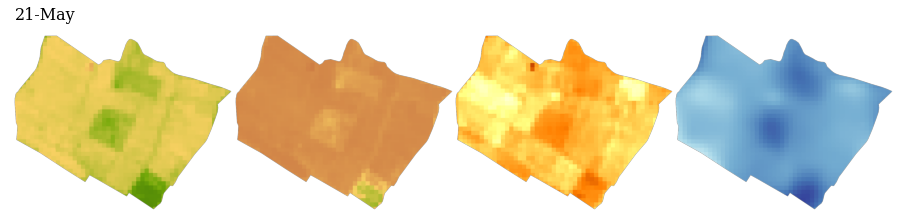

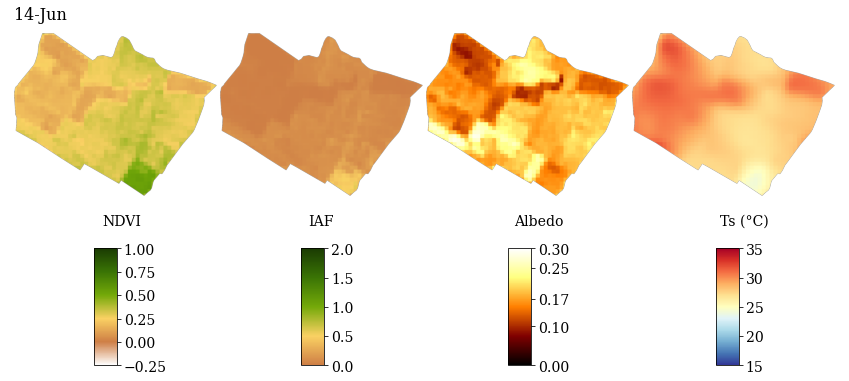

In [19]:
# Listas para iteraciones 
# Diccionarios de visualización

ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']
ndvi_cmap2 = ['ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']

vis_params_ndvi = {'min': -0.25, 
                   'max': 1, 
                   'palette': ndvi_cmap} # cmp.get_palette('RdYlGn'), ndvi_cmap

vis_params_alb = {'min': 0,
                  'max': 0.30,
                  'palette': cmp.get_palette('afmhot')}

vis_params_ts = {'min': 15, #img_productos_dict['min']['Ts_c'],
                 'max': 35, #img_productos_dict['max']['Ts_c'],
                 'palette': cmp.get_palette('RdYlBu_r')}

vis_params_lai = {'min': 0,  
                  'max': 2, 
                  'palette': ndvi_cmap2} # RdYlGn_r, afmhot, turbo_r

lista_paletas = [vis_params_ndvi, vis_params_lai, vis_params_alb, vis_params_ts]
lista_variables = ['NDVI', 'LAI', 'albedo', 'Ts_c']
lista_etiquetas = ['NDVI', 'IAF', 'Albedo', 'Ts (°C)'] 

save_filename = True # None para no guardar

for index in range(n_imgs):  
# for index in [5]:  
    
    # Selección de imagenes Landsat: 0 1 Enero, 2 Marzo, 3 Junio
    img_productos = lista_imgprocesadas[index]['img_productos']
    fecha = lista_imgprocesadas[index]['fecha']
    
    # --------------------------------------------------------------------
    # Elaboración de gráfica
    # --------------------------------------------------------------------
    
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]

    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(ncols=4, wspace=-0.05)
    axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    # Fecha ubicado a la izquierda
    axs[0].text(-79.7872, -6.594549+2*extent, lista_fechas[index], fontsize=16) 
    
    left = 0.45 # 0.875
    bottom = -0.2
    width = 0.02 # 0.02
    height = 0.325 # 0.125
    dims = 1000    
    
    extent1 = -79.78719338866794+12*extent
    extent2 = -6.605665317455976-4*extent
    
    if index != (n_imgs-1):
        for i in range(4):
            cartoee.add_layer(axs[i], 
                              img_productos.select(lista_variables[i]), 
                              dims=dims, 
                              region=zoom_region, 
                              vis_params= lista_paletas[i]) # lista_vispaletas conjunto de vis
            axs[i].axis('off')

    else:      
        # 1 NDVI
        cartoee.add_layer(axs[0], img_productos.select(lista_variables[0]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[0])
        cartoee.add_colorbar(axs[0], vis_params=lista_paletas[0], loc='right', tick_font_size=14,
                             posOpts=[0.2, bottom, width, height],
                             ticks=[-0.25, 0.0, 0.25, 0.5, 0.75, 1],
                             # discrete=True,
                             # spacing='proportional'
                            )                       
        axs[0].text(extent1, extent2, lista_etiquetas[0], fontsize=14)
        axs[0].axis('off')
        
        # 2 LAI
        cartoee.add_layer(axs[1], img_productos.select(lista_variables[1]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[1])
        cartoee.add_colorbar(axs[1], 
                             vis_params=lista_paletas[1], 
                             loc='right', 
                             tick_font_size=14,
                             posOpts=[0.38, bottom, width, height],
                             ticks=[0.0, 0.5, 1, 1.5, 2],
                             # discrete=True,
                             # spacing='proportional'
                            )
        axs[1].text(extent1, extent2, lista_etiquetas[1], fontsize=14)
        axs[1].axis('off')
        
        # 3 Albedo
        cartoee.add_layer(axs[2], img_productos.select(lista_variables[2]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[2])
        cartoee.add_colorbar(axs[2], 
                             vis_params=lista_paletas[2], 
                             loc='right', 
                             tick_font_size=14,
                             posOpts=[0.56, bottom, width, height], 
                             ticks=[0.0, 0.1, 0.17, 0.25, 0.3]) # <--- Asignación de ticks para Albedo
        axs[2].text(extent1, extent2, lista_etiquetas[2], fontsize=14)
        axs[2].axis('off')
        
        # 4 Temperatura
        cartoee.add_layer(axs[3], img_productos.select(lista_variables[3]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[3])
        cartoee.add_colorbar(axs[3], vis_params=lista_paletas[3], loc='right', tick_font_size=14,
                             posOpts=[0.74, bottom, width, height])
        axs[3].text(extent1, extent2, lista_etiquetas[3], fontsize=14)
        axs[3].axis('off')
    
    # Guardar
    if save_filename != None:
        img_name = f'Productos_{fecha}.png'
        plt.savefig(os.path.join(carpeta_output, img_name), 
                    bbox_inches='tight', pad_inches=.1, dpi=500);
    
    plt.show()

#### Gráfica Componentes Balance Radiación

In [25]:
for index in range(n_imgs):
    print(lista_fechas[index])
    img = lista_imgprocesadas_ET[index]['img_CompBalance'].select('2_H')
    pprint(get_stats(img, geometry=predios_agricolas, scale=30))

13-Ene
{'max': {'2_H': 575.0385282698877},
 'mean': {'2_H': 467.54977663232603},
 'median': {'2_H': 462.53257645714916},
 'min': {'2_H': 437.6999618221012},
 'mode': {'2_H': 456.54462256183325},
 'stdDev': {'2_H': 18.59063540600532}}
29-Ene
{'max': {'2_H': 763.911743229514},
 'mean': {'2_H': 557.1888752518483},
 'median': {'2_H': 552.9745350934287},
 'min': {'2_H': 498.51170820462056},
 'mode': {'2_H': 554.9907170484788},
 'stdDev': {'2_H': 32.86242716728654}}
10-Mar
{'max': {'2_H': 979.3932628388465},
 'mean': {'2_H': 583.9260462882357},
 'median': {'2_H': 574.2205615983075},
 'min': {'2_H': 460.1500982338207},
 'mode': {'2_H': 589.9047692874761},
 'stdDev': {'2_H': 59.91105552837284}}
05-May
{'max': {'2_H': 577.4254352513208},
 'mean': {'2_H': 421.5636022883774},
 'median': {'2_H': 418.7316955960612},
 'min': {'2_H': 301.1401387658011},
 'mode': {'2_H': 403.139978234861},
 'stdDev': {'2_H': 33.202943620188464}}
21-May
{'max': {'2_H': 448.585578820703},
 'mean': {'2_H': 389.9295547812

In [43]:
for index in range(n_imgs):
    print(lista_fechas[index])
    img = lista_imgprocesadas_ET[index]['img_CompBalance'].select('0_Rn')
    pprint(get_stats(img, geometry=predios_agricolas, scale=30))

13-Ene
{'max': {'0_Rn': 772.0077193208372},
 'mean': {'0_Rn': 685.8409591609827},
 'median': {'0_Rn': 687.385429229218},
 'min': {'0_Rn': 595.8388078712111},
 'mode': {'0_Rn': 713.4750185693233},
 'stdDev': {'0_Rn': 29.247288514140795}}
29-Ene
{'max': {'0_Rn': 769.8703497156289},
 'mean': {'0_Rn': 700.5097828381206},
 'median': {'0_Rn': 701.4187141783449},
 'min': {'0_Rn': 619.6774958773267},
 'mode': {'0_Rn': 706.495382502436},
 'stdDev': {'0_Rn': 24.267048733295145}}
10-Mar
{'max': {'0_Rn': 735.7314294163416},
 'mean': {'0_Rn': 639.8512904216018},
 'median': {'0_Rn': 636.5481826265141},
 'min': {'0_Rn': 585.8228656736294},
 'mode': {'0_Rn': 626.4592821697336},
 'stdDev': {'0_Rn': 24.67861008646526}}
05-May
{'max': {'0_Rn': 664.9684194726657},
 'mean': {'0_Rn': 590.6783008514083},
 'median': {'0_Rn': 596.4027037252724},
 'min': {'0_Rn': 445.9522454123453},
 'mode': {'0_Rn': 603.4974769218619},
 'stdDev': {'0_Rn': 31.106293315299816}}
21-May
{'max': {'0_Rn': 615.5743824971656},
 'mean'

In [26]:
for index in range(n_imgs):
    print(lista_fechas[index])
    img = lista_imgprocesadas_ET[index]['img_CompBalance'].select('3_LE_vis')
    pprint(get_stats(img, geometry=predios_agricolas, scale=30))

13-Ene
{'max': {'3_LE_vis': 252.41398470460456},
 'mean': {'3_LE_vis': 154.41818665604137},
 'median': {'3_LE_vis': 163.56290470334088},
 'min': {'3_LE_vis': 0},
 'mode': {'3_LE_vis': 174.64491252515933},
 'stdDev': {'3_LE_vis': 47.69451282704867}}
29-Ene
{'max': {'3_LE_vis': 190.01336594536315},
 'mean': {'3_LE_vis': 92.73687448628426},
 'median': {'3_LE_vis': 96.49671689850128},
 'min': {'3_LE_vis': 0},
 'mode': {'3_LE_vis': 0},
 'stdDev': {'3_LE_vis': 41.56880980794943}}
10-Mar
{'max': {'3_LE_vis': 167.8264316155961},
 'mean': {'3_LE_vis': 24.661073483757516},
 'median': {'3_LE_vis': 3.5315259149952434},
 'min': {'3_LE_vis': 0},
 'mode': {'3_LE_vis': 0.005522966123425703},
 'stdDev': {'3_LE_vis': 34.4665678882507}}
05-May
{'max': {'3_LE_vis': 261.23288535996505},
 'mean': {'3_LE_vis': 130.86966729476663},
 'median': {'3_LE_vis': 138.9639409649285},
 'min': {'3_LE_vis': 0},
 'mode': {'3_LE_vis': 141.09008150887334},
 'stdDev': {'3_LE_vis': 46.722339693818306}}
21-May
{'max': {'3_LE_v

In [59]:
vis_Rn = {'min': 400, # img_final_stats['min']['0_Rn'],
          'max': 700, #img_final_stats['max']['0_Rn'],
          'palette': cmp.get_palette('Spectral_r')} # 1. gist_rainbow_r, 2. YlGnBu

vis_G = {'min': 0,   # img_final_stats['min']['1_G'],
         'max': 100, # img_final_stats['max']['1_G'],
         'palette': cmp.get_palette('RdYlGn_r')} # 1. RdYlGn_r, 2. BrBG_r

vis_H = {'min': 300,   # img_final_stats['min']['2_H'],
         'max': 700, # img_final_stats['max']['2_H'],
         'palette': cmp.get_palette('RdYlGn_r')}

vis_LE = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 300, # img_final_stats['max']['3_LE'],
          'palette': cmp.get_palette('RdYlBu_r')} # RdYlBu_r

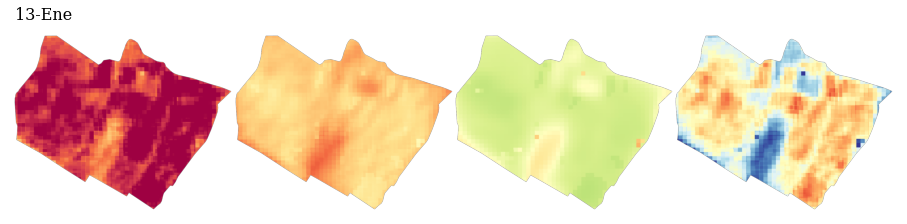

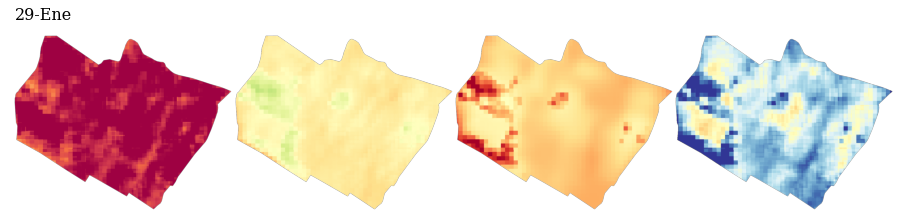

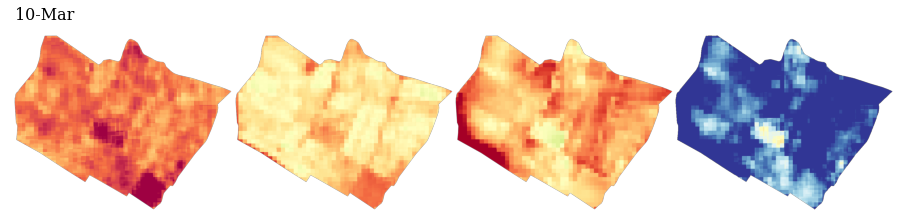

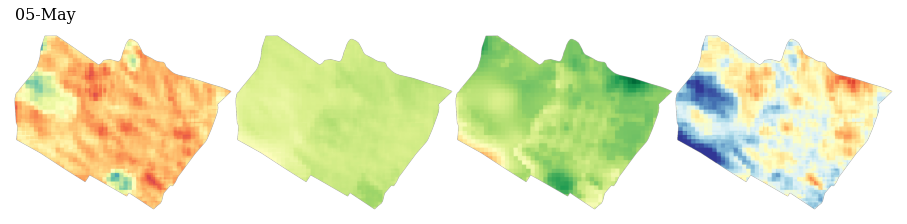

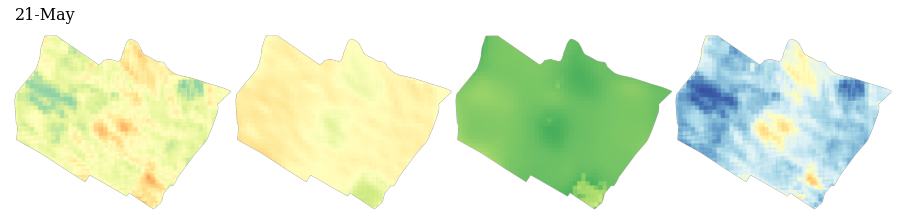

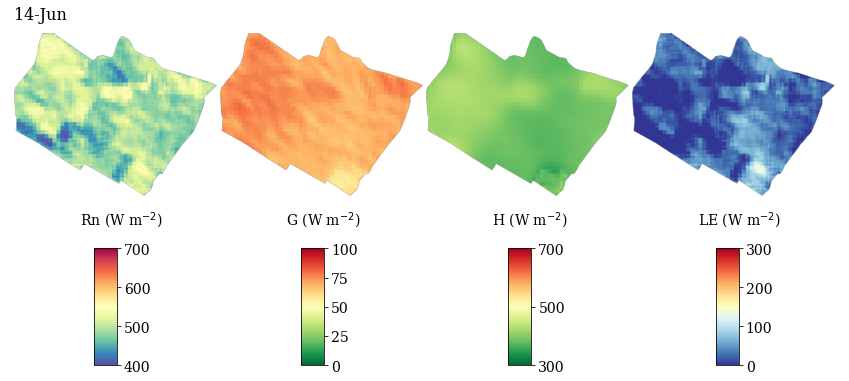

In [60]:
# Listas para iteraciones 
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']
lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '05-May', '21-May', '14-Jun']
lista_paletas = [vis_Rn, vis_G, vis_H, vis_LE]
lista_variables = ['0_Rn', '1_G', '2_H', '3_LE_vis']
lista_etiquetas = ['Rn (W/m m$^{-2}$)', 'G (W m$^{-2}$)', 'H (W m$^{-2}$)', 'LE (W m$^{-2}$)'] 

save_filename = True # None para no guardar, True u otra cosa para guardar

for index in range(n_imgs):
    
    # Selección de imagenes Landsat: 0 1 Enero, 2 Marzo, 3 Junio
    img_productos = lista_imgprocesadas_ET[index]['img_CompBalance'] # <-- Cambiar por cada grafica
    
    # --------------------------------------------------------------------
    # Elaboración de gráfica
    # --------------------------------------------------------------------
    
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]

    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(ncols=4, wspace=-0.05)
    axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    # Fecha ubicado a la izquierda
    axs[0].text(-79.7872, -6.594549+2*extent, lista_fechas[index], fontsize=16) 
    
    left = 0.45 # 0.875
    bottom = -0.2
    width = 0.02 # 0.02
    height = 0.325 # 0.125
    dims = 1000    
    
    extent1 = -79.78719338866794+9*extent
    extent2 = -6.605665317455976-4*extent
    
    if index != (n_imgs-1):
        
        for i in range(4):
            cartoee.add_layer(axs[i], 
                              img_productos.select(lista_variables[i]), 
                              dims=dims, 
                              region=zoom_region, 
                              vis_params= lista_paletas[i]) # lista_vispaletas conjunto de vis
            axs[i].axis('off')

    else:
        
        # 1. Rn
        cartoee.add_layer(axs[0], img_productos.select(lista_variables[0]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[0])
        cartoee.add_colorbar(axs[0], vis_params=lista_paletas[0], loc='right', tick_font_size=14,
                             posOpts=[0.2, bottom, width, height])                        
        axs[0].text(extent1, extent2, lista_etiquetas[0], fontsize=14)
        axs[0].axis('off')
        
        # 2. G
        cartoee.add_layer(axs[1], img_productos.select(lista_variables[1]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[1])
        cartoee.add_colorbar(axs[1], vis_params=lista_paletas[1], loc='right', tick_font_size=14,
                             posOpts=[0.38, bottom, width, height])
        axs[1].text(extent1, extent2, lista_etiquetas[1], fontsize=14)
        axs[1].axis('off')
        
        # 3. H
        cartoee.add_layer(axs[2], img_productos.select(lista_variables[2]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[2])
        cartoee.add_colorbar(axs[2], vis_params=lista_paletas[2], loc='right', tick_font_size=14,
                             posOpts=[0.56, bottom, width, height],
                             ticks=[100, 300, 500, 700]) # <-- Asignación de ticks para H
        axs[2].text(extent1, extent2, lista_etiquetas[2], fontsize=14)
        axs[2].axis('off')
        
        # 4. LE
        cartoee.add_layer(axs[3], img_productos.select(lista_variables[3]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[3])
        cartoee.add_colorbar(axs[3], vis_params=lista_paletas[3], loc='right', tick_font_size=14,
                             posOpts=[0.74, bottom, width, height],
                             ticks=[0, 100, 200, 300]) # <-- Asignación de ticks para LE
        axs[3].text(extent1, extent2, lista_etiquetas[3], fontsize=14)
        axs[3].axis('off')
    
    # Guardar
    if save_filename != None:
        img_name = f'Balance_Fecha-{index}.png'
        plt.savefig(os.path.join(carpeta_output, img_name), 
                    bbox_inches='tight', pad_inches=.1) #, dpi=400);
    
    plt.show()

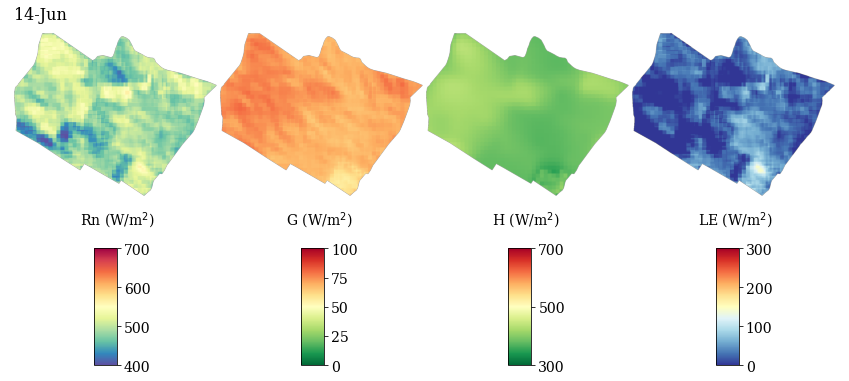

In [61]:
# Listas para iteraciones 
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']
lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '05-May', '21-May', '14-Jun']
lista_paletas = [vis_Rn, vis_G, vis_H, vis_LE]
lista_variables = ['0_Rn', '1_G', '2_H', '3_LE_vis']
lista_etiquetas = ['Rn (W/m$^{2}$)', 'G (W/m$^{2}$)', 'H (W/m$^{2}$)', 'LE (W/m$^{2}$)'] 

save_filename = True # None para no guardar, True u otra cosa para guardar

# for index in range(n_imgs):
for index in [n_imgs-1]:
    
    # Selección de imagenes Landsat: 0 1 Enero, 2 Marzo, 3 Junio
    img_productos = lista_imgprocesadas_ET[index]['img_CompBalance'] # <-- Cambiar por cada grafica
    
    # --------------------------------------------------------------------
    # Elaboración de gráfica
    # --------------------------------------------------------------------
    
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]

    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(ncols=4, wspace=-0.05)
    axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    # Fecha ubicado a la izquierda
    axs[0].text(-79.7872, -6.594549+2*extent, lista_fechas[index], fontsize=16) 
    
    left = 0.45 # 0.875
    bottom = -0.2
    width = 0.02 # 0.02
    height = 0.325 # 0.125
    dims = 1000    
    
    extent1 = -79.78719338866794+9*extent
    extent2 = -6.605665317455976-4*extent
    
    if index == (n_imgs-1):
        
        # 1. Rn
        cartoee.add_layer(axs[0], img_productos.select(lista_variables[0]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[0])
        cartoee.add_colorbar(axs[0], vis_params=lista_paletas[0], loc='right', tick_font_size=14,
                             posOpts=[0.2, bottom, width, height])                        
        axs[0].text(extent1, extent2, lista_etiquetas[0], fontsize=14)
        axs[0].axis('off')
        
        # 2. G
        cartoee.add_layer(axs[1], img_productos.select(lista_variables[1]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[1])
        cartoee.add_colorbar(axs[1], vis_params=lista_paletas[1], loc='right', tick_font_size=14,
                             posOpts=[0.38, bottom, width, height])
        axs[1].text(extent1, extent2, lista_etiquetas[1], fontsize=14)
        axs[1].axis('off')
        
        # 3. H
        cartoee.add_layer(axs[2], img_productos.select(lista_variables[2]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[2])
        cartoee.add_colorbar(axs[2], vis_params=lista_paletas[2], loc='right', tick_font_size=14,
                             posOpts=[0.56, bottom, width, height],
                             ticks=[100, 300, 500, 700]) # <-- Asignación de ticks para H
        axs[2].text(extent1, extent2, lista_etiquetas[2], fontsize=14)
        axs[2].axis('off')
        
        # 4. LE
        cartoee.add_layer(axs[3], img_productos.select(lista_variables[3]), 
                          dims=dims, region=zoom_region, vis_params= lista_paletas[3])
        cartoee.add_colorbar(axs[3], vis_params=lista_paletas[3], loc='right', tick_font_size=14,
                             posOpts=[0.74, bottom, width, height],
                             ticks=[0, 100, 200, 300]) # <-- Asignación de ticks para LE
        axs[3].text(extent1, extent2, lista_etiquetas[3], fontsize=14)
        axs[3].axis('off')
    
    # Guardar
    if save_filename != None:
        img_name = f'Balance_Fecha-{index}.png'
        plt.savefig(os.path.join(carpeta_output, img_name), 
                    bbox_inches='tight', pad_inches=.1) #, dpi=400);
    
    plt.show()

#### Gráficas 1x1

In [ ]:
# Generar gráficas de variables determinadas
# ['NDVI',  'SAVI', 'LAI', 'albedo', 'Ts_k', 'Ts_c', 't_sw', 'e_0', 'e_NB', 'cos_theta', 'cos_theta_1', 'slope', 'elevation']
for n_img, img in enumerate(lista_imgprocesadas):

    # img_rgb_sr = img['img_SR']
    img_ = img['img_productos'].select('NDVI')
    fecha = img['fecha']

    vis_params_ndvi = {'min': 0,
                       'max': 1,
                       'palette': ndvi_cmap}
    
    # vis_params_sr = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0, 'max': 0.3, 'gamma':1.3}
    vis_params_alb = {
        'min': 0,
        'max': 0.25,
        'palette': ndvi_cmap#cmp.get_palette('gray') 
    }
    
    title_map = f'{fecha} - NDVI'
    
    get_grafica_cartoee_color(img_.clip(predios_agricolas).blend(predios_vis), 
                                  vis_params_ndvi,                              
                                  text=None, 
                                  title_map=title_map,
                                  label='NDVI', 
                                  save_fig=f'{fecha}_NDVI',
                                  nogrid=True)

#### Gráfica ET

In [13]:
# Preparamos una lista con imagenes de ET
lista_et = []
for i in range(n_imgs):
    lista_et.append(lista_imgprocesadas_ET[i]['img_ETinst']) # Banda 'ET'
    
pprint(lista_et)

# Convertimos la lista de imagenes en una sola con cada elemento como banda
img_ET_final = ee.Image(lista_et) 
img_ET_final.bandNames().getInfo() # Asigna el sufijo _# dependiendo del número de bandas comenzando desde el segundo con _1

['ET', 'ET_1', 'ET_2', 'ET_3', 'ET_4', 'ET_5']

##### Gráfica ET 1x7 (Muy largo y no se ubica bien la rampa de color)

C:\Users\USUARIO\anaconda3\envs\gee\lib\site-packages\geemap\cartoee.py:407: UserWarning: discrete keyword used when "palette" key is supplied with visParams, creating a continuous colorbar...
  warnings.warn(


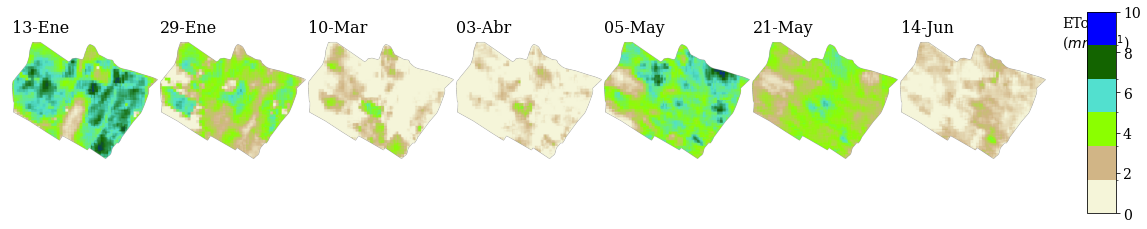

In [12]:
# --------------------------------------------------------------------
# Elaboración de gráfica de ET con 4 columnas y 1 fila
# Requisito: Tener las 4 imagenes de ET guardadas en una lista
# --------------------------------------------------------------------
# Parámetros previos
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '14-Jun']
lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May','14-Jun']
# lista_fechas = ['03-Abr', '05-May', '21-May', '14-Jun'] # <------------
imgs_ET = lista_et

# Parametros de visualización
# paleta_ET = cmp.get_palette('RdYlGn_r')
# paleta_ET.insert(0, 'FFFFFF')
paleta_ET = ["F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"]
vis_ET = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 10, # img_final_stats['max']['3_LE'],
          'palette': paleta_ET}

# Gráfica
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(ncols=n_imgs, wspace=-0.05) 
axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

extent = 0.0005

extent1 = -79.77332525015065+3*extent
extent2 = -6.594549-extent

zoom_region = [
    -79.77332525015065+extent, -6.605665317455976-extent,
    -79.78719338866794-extent, -6.594549+extent
]

posOpts = [
    0.875, # left
    0.30,  # bottom
    0.02,  # width
    0.35   # height
]

for i in range(n_imgs):
    axs[i].text(-79.7872, -6.594549+2*extent, lista_fechas[i], fontsize=16)
    cartoee.add_layer(axs[i], imgs_ET[i], dims=1000, region=zoom_region, vis_params=vis_ET)
    axs[i].axis('off')
    
ticks = np.arange(-2, 12+1, 2)
cartoee.add_colorbar(axs[n_imgs-1], vis_params=vis_ET, loc='right', 
                     posOpts=posOpts, tick_font_size=14, ticks=ticks, discrete=True)
axs[n_imgs-1].minorticks_on()
axs[n_imgs-1].text(extent1, extent2, 'ETc\n($mm\;d^{-1}$)', fontsize=14)

# Guardar imagen
# img_name = 'output/ETinst.jpg'
# plt.savefig(img_name, bbox_inches='tight', pad_inches=.1) #, dpi=400);

plt.show()

##### Gráficas 1x1

Producir 6 imágenes como mosaico y agregar la última 

In [57]:
# Función
def get_grafica_cartoee_color(image, 
                              vis_params,
                              figsize=None,                             
                              text=None, 
                              title_map=None,
                              label=None, 
                              save_fig=None,
                              nogrid=None,
                              scale_bar=None):
    
    """Obtener gráficas con cartoee
    La variable zoom_region debe asignarse según la zona de estudio.
    Para modificaciones seguir: https://geemap.org/cartoee/#cartoee-module
    """

    # Establecer área de plot usando las coordenadas de predios_bound.coordinates().getInfo()
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]
    
    # Establecer figsize para plot
    if figsize == None:
        # fig = plt.figure(figsize=(5,5)) # Para juntar en forma de mosaicos
        fig = plt.figure(figsize=(8,6)) # Para analizar
        # fig = plt.figure(figsize=(16,12)) # Para recortar la barra
    else:
        fig = plt.figure(figsize=figsize) # Para analizar
    
    # ee.Image a plotear
    ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

    # Añadir grillas
    if nogrid == True:
        ax.axis('off')
    else:
        cartoee.add_gridlines(ax, 
                              interval=0.005, 
                              ytick_rotation=90, 
                              linestyle=":", 
                              linewidth=0 # Grillas invisibles
                              ) # xtick_rotation=45

    # Añadir barra de color
    if label != None:
        cartoee.add_colorbar(ax, 
                             vis_params=vis_params, 
                             loc='right', 
                             # label=label, 
                             #posOpts=[0.86, 0.25, 0.02, 0.5],
                             posOpts= [
                                 0.9, # left
                                 0.25,  # bottom
                                 0.04,  # width
                                 0.5   # height
                                 ],
                             tick_font_size=14,
                             # ticks= [0,2,4,6,8,10],
                             # drawedges=True, 
                             # extend='both', # Genera flechas hacia los extremos
                             discrete=True,
                             spacing='proportional'
                             )
        ax.text(-79.77332525015065+2*extent, -6.594549+2*extent, label, fontsize=16)
    
    # Añadir texto
    if title_map != None:
        ax.set_title(title_map) # , fontsize=11
        
    if text != None:
        ax.text(-79.7872, -6.594549+2*extent, text, fontsize=16) 
        # fontsize=18 para mejor visibilidad en mosaicos
        
    # add scale bar
    if scale_bar != None:
        scale_bar_dict = {
            "length": 100, 
            "xy": (0.9, 0.05), 
            "linewidth": 2,
            "fontsize": 12,
            "color": "black",
            "unit": "m",
            "ha": "center",
            "va": "bottom",    
        }
        cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

    ax.tick_params(axis = 'both') # , labelsize = 9
    
    # Guardar graficas
    if save_fig != None:
        plt.savefig(save_fig + '.png', bbox_inches = 'tight', pad_inches = .1)#, dpi=400)
        # Recortar márgenes con ayuda de bbox_inches y pad_inches
        
    plt.show()

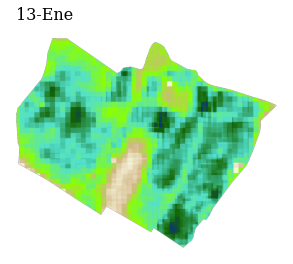

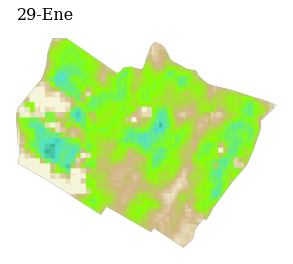

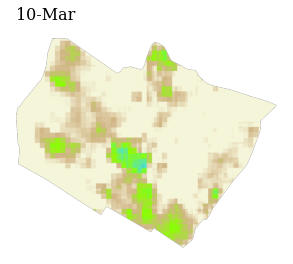

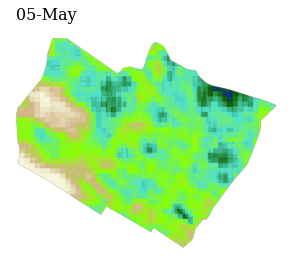

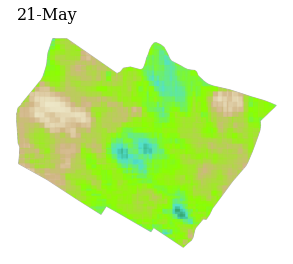

In [68]:
# Parámetros de visualización
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May','14-Jun']
imgs_ET = lista_et

paleta_ET = ["#F5F5D9", "#D1B586", "#8BFF00", "#52E0CF", "#136400", "#0000FF"] # "F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"
vis_ET = {'min': 0, 'max': 10, 'palette': paleta_ET}

for i in range(n_imgs-1):
    nombre_img = f"ET_{lista_imgprocesadas[i]['fecha']}_3"
    get_grafica_cartoee_color(imgs_ET[i], 
                              vis_ET,      
                              figsize=(5,5),
                              text=lista_fechas[i],  
                              save_fig=os.path.join(carpeta_output, nombre_img),
                              nogrid=True)

In [ ]:
# # Prueba Discretización
# img = imgs_ET[0]

# img_et_prueba = {
#     ee.Image(0)
#     .where(img.gte(0),1)
#     .where(img.gte(2),2)
#     .where(img.gte(4),3)
#     .where(img.gte(6),4)
#     .where(img.gte(8),5)
#     .where(img.gte(10),6).clip(predios_agricolas)
# }

# viz_clas = {'palette': ["#F5F5D9", "#D1B586", "#52E0CF", "#8BFF00", "#136400", "#0000FF"],
#             'min': 1,
#             'max': 6}
# # Mapas
# Map = geemap.Map()
# Map.centerObject(img_et_prueba, 16)
# Map.addLayer(img_et_prueba, viz_clas, 'img_et_prueba')
# Map

Generar la última imagen con rampa de color para añadirlo al final

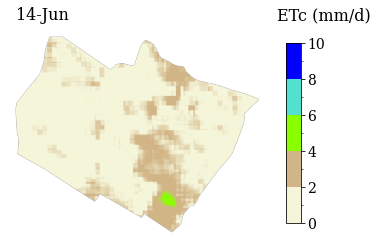

In [91]:
paleta_ET = ["#F5F5D9", "#F5F5D9", "#D1B586", "#D1B586", "#8BFF00", "#8BFF00", "#52E0CF", "#52E0CF", "#0000FF", "#0000FF"] # "F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"
vis_ET = {'min': 0, 'max': 10, 'palette': paleta_ET}

get_grafica_cartoee_color(imgs_ET[-1], 
                          vis_ET,      
                          figsize=(5,5),
                          text=lista_fechas[-1], 
                          title_map=None,
                          label= 'ETc (mm/d)', #'ETc ($mm\;d^{-1}$)', 
                          # save_fig=os.path.join(carpeta_output, f"ET_{lista_imgprocesadas[-1]['fecha']}"),
                          nogrid=True,
                          scale_bar=None)

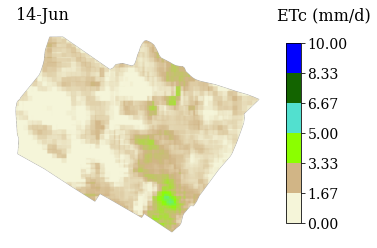

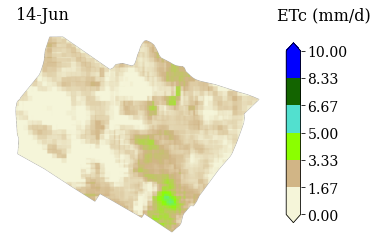

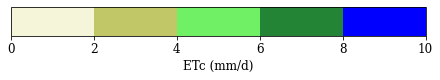

In [100]:
# Barra de color
import matplotlib.pyplot as plt
import matplotlib as mpl
from colour import Color

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

bounds = [0, 2, 4, 6, 8, 10]
paleta = ["#F5F5D9","#D1B586","#8BFF00","#52E0CF","#136400","#0000FF"] 
cmap = mpl.colors.LinearSegmentedColormap.from_list("",  [ Color(c1).rgb for c1 in paleta])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             spacing='proportional',
             label="ETc (mm/d)");

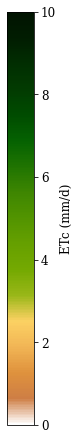

In [94]:
fig, ax = plt.subplots(figsize=(1, 6), layout='constrained')

paleta = ["#F5F5D9","#D1B586","#8BFF00","#52E0CF","#136400","#0000FF"] 
cmap_lai2 = ['#ffffff', 
             '#ce7e45', '#df923d', '#f1b555', '#fcd163', 
             '#99b718', '#74a901', '#66a000', '#529400', 
             '#3e8601', '#207401', '#056201', '#004c00', 
             '#023b01', '#012e01', '#011d01', '#011301']
cmap = mpl.colors.LinearSegmentedColormap.from_list("",  [ Color(c1).rgb for c1 in cmap_lai2])
norm = mpl.colors.Normalize(vmin=0, vmax=10)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label="ETc (mm/d)")
# fig.savefig('scalebar_dpi500.png', dpi=500)

### Gráfica Boxplot

1. Import de archivo `.shp` de variedades

In [7]:
# Imports
path_parcelas = r'input/Parcelas_wgs84_clip.shp'
fcol_parcelas = geemap.shp_to_ee(path_parcelas)

# 5 Variedades de arroz
fcol_parcelas_var1 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'CAPOTEÑA')
fcol_parcelas_var2 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'GALAN')
fcol_parcelas_var3 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'PAKAMURO')
fcol_parcelas_var4 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'PUNTILLA')
fcol_parcelas_var5 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'VALOR')

# 2 Tipos de siembra
fcol_parcelas_met1 = fcol_parcelas.filterMetadata('Metodo_de_', 'equals', 'TRANSPLANTE')
fcol_parcelas_met2 = fcol_parcelas.filterMetadata('Metodo_de_', 'equals', 'SIEMBRA DIRECTA')

# Listas con nombres
variedades_list = ['Capoteña', 'Galan', 'Pakamuro', 'Puntilla', 'Valor']
list_met_names = ['Transplante', 'Siembra Directa']

2. Procesado para boxplot

Inputs:
- Imagen de ET por fecha y con valores positivos
- Shapefiles de áreas a analizar

Procesamiento:
- Extraer valores de pixeles dentro de las áreas a analizar: 
    - Tipos de cultivos (5 tipos)
    - Tipos de siembra (2 tipos)

In [8]:
# Preparamos una lista con imagenes de ET
lista_et = []
for index in range(n_imgs):
    lista_et.append(lista_imgprocesadas_ET[index]['img_ETinst']) # Banda 'ET'
    
pprint(lista_et)

['ET', 'ET_1', 'ET_2', 'ET_3', 'ET_4', 'ET_5']

In [49]:
# Armamos una lista con todos los valores de ET extraidos por cada shapefile
lista_ET_valores_boxplot = []
for img_ET in lista_et:
    
    img_ET_pos = img_ET.updateMask(img_ET.gte(0))#.blend(predios_vis) # <--- Valores positivos de ET
    # img_ET_neg = img_ET_inst.updateMask(img_ET_inst.lt(0))#.blend(predios_vis)
    
    # 5 Tipos de cultivos
    list_et_val1 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var1, 30).get('ET') # 'CAPOTEÑA'
    list_et_val2 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var2, 30).get('ET') # 'GALAN'
    list_et_val3 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var3, 30).get('ET') # 'PAKAMURO'
    list_et_val4 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var4, 30).get('ET') # 'PUNTILLA'
    list_et_val5 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var5, 30).get('ET') # 'VALOR'
    
    list_values = ee.List([list_et_val1, list_et_val2, list_et_val3, list_et_val4, list_et_val5])
    
    # 2 Tipos de siembra
    list_et_met1 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_met1, 30).get('ET') # 'TRANSPLANTE'
    list_et_met2 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_met2, 30).get('ET') # 'SIEMBRA DIRECTA
    
    list_met = ee.List([list_et_met1, list_et_met2])
    
    dict_boxplot = {
        'list_values': list_values,
        'list_met': list_met
    }
    
    valores_boxplot = ee.Dictionary(dict_boxplot)
    lista_ET_valores_boxplot.append(valores_boxplot)
    
# Accedemos con .get
# valores_boxplot.get('list_values').getInfo()
# valores_boxplot.get('list_met').getInfo()

3. Boxplot con seaborn

El boxplot se armará mediante un DataFrame con los datos de los pixeles (uno muy grande por cierto). 

Referencia: [Seaborn - boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

Procesamiento:
- Armar el DataFrame por tipo con `pd.concat`

In [22]:
import seaborn as sns

def prepare_df_vertical(lista_escogida, lista_title, column_name):
    df = pd.DataFrame(list(zip(lista_escogida)), columns=['Valores'])
    df[column_name] = lista_title
    return df

Exportar datos

In [41]:
list_dates = ['2022-01-13', '2022-01-29', '2022-03-10', '2022-05-05', '2022-05-21', '2022-06-14']

# Armar los dataframe por fecha
for index, fecha in enumerate(list_dates):

    ee_list_values = lista_ET_valores_boxplot[index].get('list_values').getInfo()
    ee_list_met = lista_ET_valores_boxplot[index].get('list_met').getInfo()
    
    # fecha proviene de correr la celda de radiación neta
    df_var = pd.concat(
        [prepare_df_vertical(ee_list_values[i], variedades_list[i], 'Variedad') for i in range(5)]
        ).reset_index(drop=True)
    df_met = pd.concat(
        [prepare_df_vertical(ee_list_met[i], list_met_names[i], 'Metodo') for i in range(2)]
        ).reset_index(drop=True)
    
    df_var['Fecha'] = fecha
    df_met['Fecha'] = fecha
    
    df_var.to_csv(f'output/{fecha}_df_var_boxplot.csv', encoding='utf-8-sig', index=False)
    df_met.to_csv(f'output/{fecha}_df_met_boxplot.csv', encoding='utf-8-sig', index=False)

    print(f'output/{fecha}_df_var_boxplot.csv Listo!')
    print(f'output/{fecha}_df_met_boxplot.csv Listo!')

Importar datos

In [42]:
# Importar cada dataframe de las fechas y concatenarlas en uno solo
df_var = pd.concat([
    pd.read_csv(f'output/{fecha}_df_var_boxplot.csv') for fecha in list_dates
])
    
df_met = pd.concat([
    pd.read_csv(f'output/{fecha}_df_met_boxplot.csv') for fecha in list_dates
])

In [64]:
# Prueba de valores únicos
print(df_var.Variedad.value_counts())
print(df_met.Metodo.value_counts())

Variedad
Pakamuro    3029
Valor       1459
Galan       1078
Puntilla     375
Capoteña     173
Name: count, dtype: int64
Metodo
Siembra Directa    3122
Transplante        2992
Name: count, dtype: int64


In [43]:
# Prueba
df_met_mod = df_met.copy()
df_met_mod['Fecha'] = 'Total'
df_met_mod

,Valores,Metodo,Fecha
0,2.965952,Transplante,Total
1,2.850396,Transplante,Total
2,4.168058,Transplante,Total
3,3.787178,Transplante,Total
4,4.180753,Transplante,Total
...,...,...,...
929,2.639592,Siembra Directa,Total
930,1.931328,Siembra Directa,Total
931,1.010018,Siembra Directa,Total
932,2.420385,Siembra Directa,Total


In [14]:
# Original
df_met_mod = df_met.copy()
df_met_mod['Fecha'] = 'Total'
df_met_mod

,Valores,Metodo,Fecha
0,1.311557,Transplante,Total
1,1.070096,Transplante,Total
2,1.706649,Transplante,Total
3,1.057413,Transplante,Total
4,0.677171,Transplante,Total
...,...,...,...
455,3.775905,Siembra Directa,Total
456,2.517774,Siembra Directa,Total
457,1.191346,Siembra Directa,Total
458,3.092585,Siembra Directa,Total


In [29]:
# Prueba
df_var_mod = df_var.copy()
df_var_mod['Fecha'] = 'Total'
df_var_mod

,Valores,Variedad,Fecha
0,3.257524,Capoteña,Total
1,3.198174,Capoteña,Total
2,3.102134,Capoteña,Total
3,3.445272,Capoteña,Total
4,3.123060,Capoteña,Total
...,...,...,...
929,2.289865,Valor,Total
930,2.496658,Valor,Total
931,2.403028,Valor,Total
932,2.286535,Valor,Total


In [15]:
# Original
df_var_mod = df_var.copy()
df_var_mod['Fecha'] = 'Total'
df_var_mod

,Valores,Variedad,Fecha
0,1.546960,Capoteña,Total
1,0.907040,Capoteña,Total
2,1.851302,Capoteña,Total
3,0.640290,Capoteña,Total
4,1.377977,Capoteña,Total
...,...,...,...
455,1.662889,Valor,Total
456,1.265896,Valor,Total
457,1.534039,Valor,Total
458,1.696364,Valor,Total


Por modificar:
- Aumentar tipo de fuente de los xlabel 
- Cambiar xlabel por el formato a usarse del articulo '12-Ene'

In [30]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17992\897768794.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs0[1].set_xticklabels(lista_fechas, fontsize=16)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17992\897768794.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs1[1].set_xticklabels(['Total'], fontsize=16)


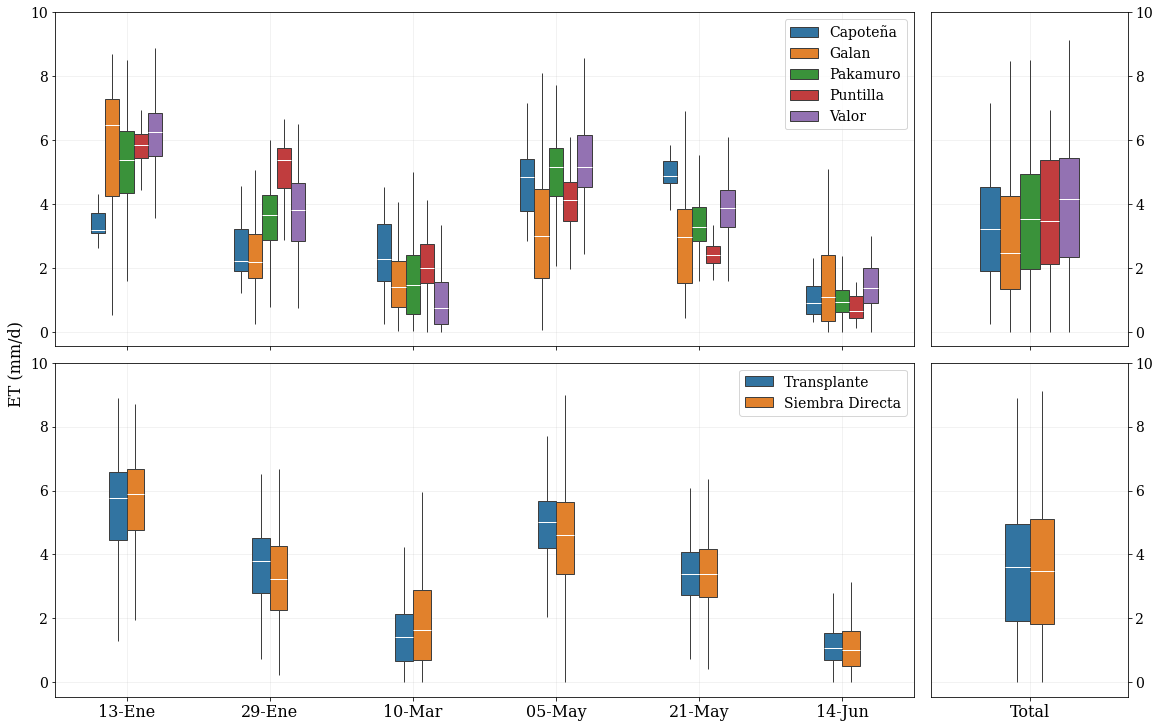

In [60]:
fontsize_legend = 14

# Diagrama de cajas con todas las fechas procesadas
fig = plt.figure(layout="constrained", figsize=(16,10))
subfigs = fig.subfigures(1, 2, width_ratios=[4, 1.])

# fig.suptitle('Diagrama de cajas - Evapotranspiración', fontsize=14)

# Sección izquierda ====================================
# Superior
axs0 = subfigs[0].subplots(2, 1, sharex=True)
subfigs[0].supylabel('ET (mm/d)', fontsize=16)
sns.boxplot(x="Fecha", y="Valores", hue='Variedad', data=df_var, 
            ax=axs0[0],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.5,
            medianprops={'color':'white'})
axs0[0].legend(fontsize=fontsize_legend)
# axs0[0].tick_params(axis='y', labelsize=14)
axs0[0].set_xlabel('')
axs0[0].set_ylim(top=10)
axs0[0].set_ylabel('')
axs0[0].grid(alpha=.2)

# Inferior
sns.boxplot(x="Fecha", y="Valores", hue='Metodo', data=df_met, 
            ax=axs0[1],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.25,
            medianprops={'color':'white'})
axs0[1].legend(fontsize=fontsize_legend)
# axs0[1].tick_params(axis='y', labelsize=14)
axs0[1].set_ylabel('')
axs0[1].set_ylim(top=10)
axs0[1].set_xticklabels(lista_fechas, fontsize=16)
axs0[1].set_xlabel('')
axs0[1].grid(alpha=.2)


# Sección derecha ====================================
# Superior
axs1 = subfigs[1].subplots(2, 1, sharex=True)
sns.boxplot(x="Fecha", y="Valores", hue='Variedad', data=df_var_mod,
            ax=axs1[0],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.5,
            medianprops={'color':'white'})
axs1[0].yaxis.set_ticks_position("right")
# axs1[0].tick_params(axis='y', labelsize=14)
axs1[0].get_legend().remove()
axs1[0].set_ylabel('')
axs1[0].set_ylim(top=10)
axs1[0].set_xlabel('')
axs1[0].grid(alpha=.2)

# Inferior
sns.boxplot(x="Fecha", y="Valores", hue='Metodo', data=df_met_mod,
            ax=axs1[1],
            showcaps=False, #palette=['green','yellow','#f53232', '#FFFFFF', '#00B0FF'], 
            fliersize=0, 
            linewidth=1,
            width=0.25,
            medianprops={'color':'white'})
axs1[1].yaxis.set_ticks_position("right")
axs1[1].get_legend().remove()
axs1[1].set_ylabel('')
axs1[1].set_ylim(top=10)
axs1[1].set_xlabel('')
axs1[1].set_xticklabels(['Total'], fontsize=16)
# axs1[1].tick_params(axis='y', labelsize=14)
axs1[1].grid(alpha=.2);

plt.savefig('output/ETinst_Boxplot.png');